# Instagram Influencers Analysis
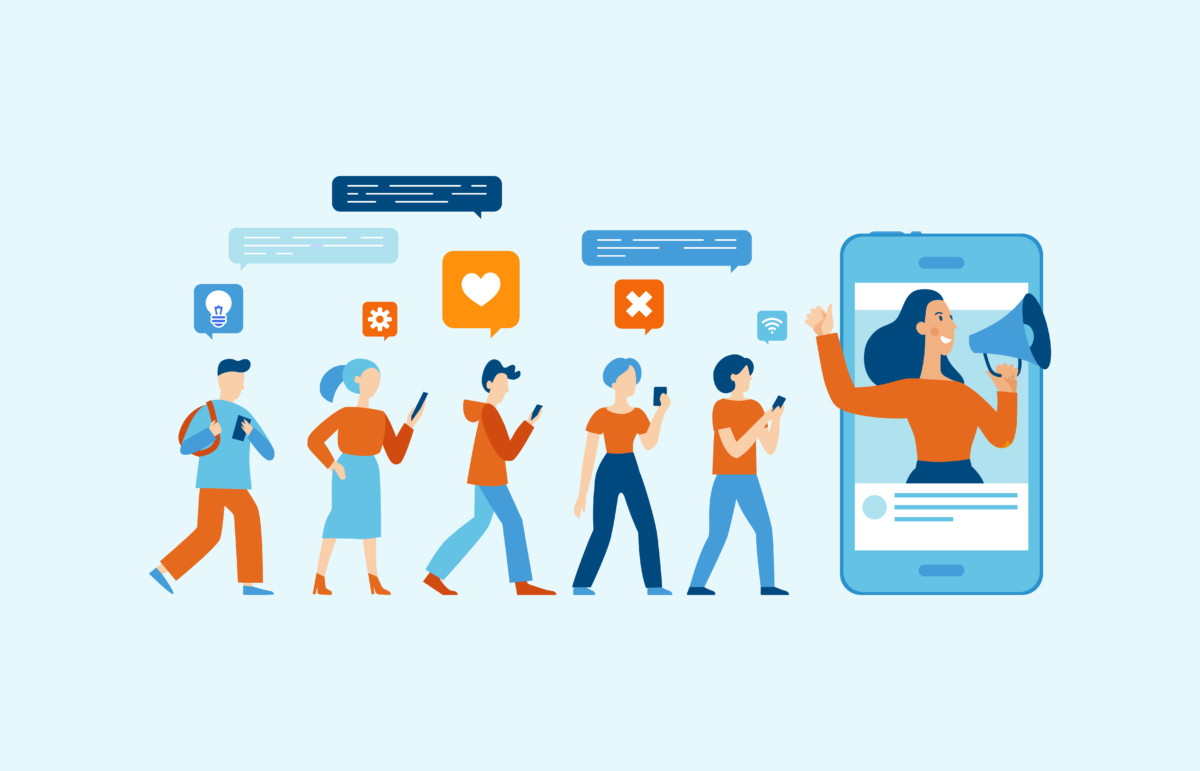

## Context
* Instagram is one of the most popular social media websites with about 1 billion active users. 
* Instagram marketing has proliferated as a source for companies to market their products with one way known as Brand-sponsored post.
* This involves Instagram users known as "Influencers" to post about a brand or particular product in exchange for a fee/gift for the post.

**This project aims to identify whether a post is sponsored, who the sponsor is.**

In [256]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.tokenize import sent_tokenize, word_tokenize
from textblob import TextBlob
import spacy
import re
from pytrends.request import TrendReq
import datetime
import time
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.express as px
init_notebook_mode(connected=True)

pd.set_option('display.max_rows', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Calven\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [257]:
influencers_raw = pd.read_csv("C:/Users/Calven/Documents/Projects\data/influencers.csv",encoding='ISO 8859-1')
orgcorpus_raw = pd.read_csv("C:/Users/Calven/Documents/Projects\data/orgcorpus.txt", sep=",", header=None).values.tolist()[0]

influencers_raw.head()
influencers_raw.describe()

,id,User,Followers,Postdate,Likes,Comments,Caption,Industry,Country
0,1,alinagavrilov_,101622.0,24/11/2021 3:26,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States
1,2,alinagavrilov_,101622.0,21/11/2021 21:21,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States
2,3,alinagavrilov_,101622.0,16/11/2021 2:13,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States
3,4,alinagavrilov_,101622.0,15/11/2021 1:30,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States
4,5,alinagavrilov_,101622.0,13/11/2021 18:04,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States


,id,Followers,Likes,Comments
count,2602.000000,2.592000e+03,2547.000000,2602.000000
mean,1307.205995,1.971299e+05,5171.580683,79.182552
std,753.107026,2.562216e+05,21706.305127,560.178704
min,1.000000,6.420000e+02,-1.000000,0.000000
25%,658.250000,2.672500e+04,306.000000,7.000000
50%,1308.500000,9.704550e+04,1044.000000,20.000000
75%,1958.750000,2.864040e+05,3904.000000,50.000000
max,2609.000000,2.477901e+06,595464.000000,20310.000000


# Exploratory Data Analysis

## Data Cleaning

**Check Unique Columns and DataTypes**

In [258]:
influencers_raw['User'].nunique()
influencers_raw['Industry'].nunique()
influencers_raw['Country'].nunique()

influencers_raw.dtypes

467

34

28

id             int64
User          object
Followers    float64
Postdate      object
Likes        float64
Comments       int64
Caption       object
Industry      object
Country       object
dtype: object

**Check for Missing Values**

In [259]:
influencers_raw.isnull().values.any()
print('There are ' + str(influencers_raw['User'].isnull().sum()) + ' missing values in User column.')
print('There are ' + str(influencers_raw['Industry'].isnull().sum()) + ' missing values in Industry column.')
print('There are ' + str(influencers_raw['Country'].isnull().sum()) + ' missing values in Country column.')
print('There are ' + str(influencers_raw['Caption'].isnull().sum()) + ' missing values in Caption column.')

True

There are 5 missing values in User column.
There are 378 missing values in Industry column.
There are 0 missing values in Country column.
There are 52 missing values in Caption column.


**Replace missing values in Industry column as "General"**

In [260]:
inf_df = influencers_raw.copy()
inf_df['Industry'] = inf_df['Industry'].fillna('General')

**Drop all NA on Caption Column**
* As we are finding if a post is sponsored or not, posts' with no caption will serve us no purpose.

In [261]:
inf_df = inf_df[inf_df['Caption'].notna()]

**Check for Duplicates/Re-entries**

In [262]:
inf_df['Caption'].duplicated().any()

inf_df[inf_df.duplicated(subset=['User','Caption','Postdate'], keep=False)].head(5)

True

,id,User,Followers,Postdate,Likes,Comments,Caption,Industry,Country
943,951,evanmenswear,17846.0,24/10/2019 10:59,407.0,1,Letâs get inspired by our comfy looks. We al...,Fashion,Netherlands
944,952,evanmenswear,17846.0,24/10/2019 10:59,854.0,0,Letâs get inspired by our comfy looks. We al...,Fashion,Netherlands
1105,1113,peddey_,57593.0,25/11/2021 14:15,4106.0,2,Reklame || @itsmay.dk holder black friday klok...,General,Denmark
1106,1114,peddey_,57593.0,23/11/2021 15:10,5680.0,1365,Reklame || Det er tid til en GIVEAWAY!ð\n\n...,General,Denmark
1107,1115,peddey_,57593.0,20/11/2021 15:33,4359.0,9,Reklame for @tisedenmark || Tise er en app hvo...,General,Denmark


**Drop Duplicates**

In [263]:
inf_df = inf_df.drop_duplicates(['User','Caption','Postdate'],keep= 'last')

**Convert Postdate to datetime format from object**

In [264]:
inf_df['Postdate'] = pd.to_datetime(inf_df['Postdate'])
# Set Postdate as index
inf_df = inf_df.set_index('Postdate')

## Feature Generation

#### Quantifying Engagement Rate

In [265]:
inf_df['Engagement Rate'] = ((inf_df['Comments']+inf_df['Likes'])/inf_df['Followers'])*100
inf_df.head(5)
inf_df.describe()
#Drop column id
inf_df.drop('id', axis=1, inplace=True)

,id,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate
Postdate,,,,,,,,,
2021-11-24 03:26:00,1,alinagavrilov_,101622.0,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States,0.858082
2021-11-21 21:21:00,2,alinagavrilov_,101622.0,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States,0.600264
2021-11-16 02:13:00,3,alinagavrilov_,101622.0,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States,0.953534
2021-11-15 01:30:00,4,alinagavrilov_,101622.0,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States,1.132629
2021-11-13 18:04:00,5,alinagavrilov_,101622.0,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States,0.404440


,id,Followers,Likes,Comments,Engagement Rate
count,2505.000000,2.495000e+03,2450.000000,2505.000000,2440.000000
mean,1310.322156,2.021951e+05,5315.633469,80.039920,3.159182
std,760.072053,2.588686e+05,22073.355991,569.581608,4.927235
min,1.000000,6.420000e+02,-1.000000,0.000000,-0.000771
25%,647.000000,2.752000e+04,338.000000,7.000000,0.638567
50%,1328.000000,1.022970e+05,1103.000000,20.000000,1.632807
75%,1975.000000,3.005780e+05,4039.000000,51.000000,3.699667
max,2609.000000,2.477901e+06,595464.000000,20310.000000,70.779697


#### Extracting Links

In [266]:
pattern = r'(https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}[-a-zA-Z0-9()@:%_+.~#?&/=]*)'
inf_df['Links'] = ''
inf_df['Links']= inf_df["Caption"].str.extract(pattern, expand=True)

# Show those that have links in their caption
inf_df[inf_df['Links'].notna()].head(5)

,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate,Links
Postdate,,,,,,,,,
2021-11-24 03:26:00,alinagavrilov_,101622.0,857.0,15,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,Fashion,United States,0.858082,http://liketk.it/3sIrL
2021-11-21 21:21:00,alinagavrilov_,101622.0,576.0,34,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,Fashion,United States,0.600264,http://liketk.it/3stYQ
2021-11-16 02:13:00,alinagavrilov_,101622.0,937.0,32,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,Fashion,United States,0.953534,http://liketk.it/3s2rk
2021-11-15 01:30:00,alinagavrilov_,101622.0,1097.0,54,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,Fashion,United States,1.132629,http://liketk.it/3rWW0
2021-11-13 18:04:00,alinagavrilov_,101622.0,383.0,28,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,Fashion,United States,0.404440,http://liketk.it/3rQLO


## Identifying Sponsored Posts
We identify whether a post is sponsored or not manually through
- tagging a relevant organization with @ sign

In [267]:
# Load NLP model
nlp = spacy.load('en_core_web_lg')
stop_words = set(stopwords.words("english"))

**Clean and Tokenize Caption**

In [268]:
def tokens(list_words):
    nonTokenWords = []
    for i in list_words:
        if ((str(i).lower() not in stop_words and str(i).isalnum()) and bool(re.match('^[a-zA-Z0-9]+$', str(i))))  or "@" in str(i):
            nonTokenWords.append(str(i).lower())
    return nonTokenWords

inf_df['segment_caption'] = inf_df.apply(lambda row: nlp(str(row.Caption)) , axis=1)
inf_df['clean_caption'] = inf_df.apply(lambda row: tokens(row.segment_caption) ,axis=1)

**Get Possible Sponsor (At Sign - Tagging & Entity/Org identification)**

In [269]:
def remove_emoji(string, boo):
           #text = text.decode()
            #text = emoji.get_emoji_regexp().sub(u'', text)
            #text = re.sub(r'[^\x00-\x7f]',r'', text) 
            #.encode("utf8", "ignore") 
    emoji_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u"\U00010000-\U0010ffff"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u200d"
      u"\u23cf"
      u"\u23e9"
      u"\u231a"
      u"\ufe0f"
      "]+", flags = re.UNICODE)
    text = emoji_pattern.sub(r'', string)
    text = text.encode("ascii", "ignore").decode()
    text = text.replace("\\n","").replace("\n","").replace("!","").replace(",","").replace("#","").replace("?","").replace("whats","").replace("heres","")
    if boo:
        if any(i.isdigit() for i in text) and any(i.isalpha() for i in text) and not(' ' in text)    :
            return ""
    bool = False
    out = ""
    count = 0
    for t in text:
        if t == '\\':
            if bool:
                continue
            else:
                bool = True
                count += 1
                continue
        if count > 0 and count <= 4:
            count += 1
            continue
        if count == 5:
            count = 0   
        bool = False
        out += t
    return(out)
'''
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
'''
def pairList(list_words):
    pairList = []
    for e in list_words.ents:
        if e.label_ == "ORG" or  e.label_ == "PRODUCT" :
            text = remove_emoji(e.text, True)
            if text == "":
                continue
            pairList.append(text.lower().strip().replace("@",""))
        else:
            continue
    return list(filter(None, set(pairList)))

def getTag(list_words):
    nonTokenWords = []
    for i in list_words:
        if ("@" in str(i) or "orgcorpus_raw" in str(i)):
            text = remove_emoji(str(i), False)
            nonTokenWords.append(text.lower().replace("@",""))
    return list(filter(None, set(nonTokenWords)))


def removeDuplicate(dupList):
    return list( dict.fromkeys(dupList) )

def checksponsored(row):
    if ((len(row['Sponsor']) > 0 )  or (len(row['Tag']) > 0)) :
        return "Yes"
    else:
        return "No"

#inf_df['Caption']=inf_df['Caption'].apply(lambda x: remove_emoji(x))
inf_df['Tag'] = inf_df.apply(lambda row: getTag(row.segment_caption), axis = 1)
inf_df['Sponsor'] = inf_df.apply(lambda row: pairList(row.segment_caption) , axis=1)
inf_df['Sponsor'] = inf_df['Sponsor'] + inf_df['Tag']  
inf_df['Sponsor'] = inf_df.apply(lambda row: removeDuplicate(row.Sponsor) , axis=1)

'\ndef remove_emoji(text):\n    emoji_pattern = re.compile("["\n                           u"😀-🙏"  # emoticons\n                           u"🌀-🗿"  # symbols & pictographs\n                           u"🚀-\U0001f6ff"  # transport & map symbols\n                           u"\U0001f1e0-🇿"  # flags (iOS)\n                           u"✂-➰"\n                           u"Ⓜ-🉑"\n                           "]+", flags=re.UNICODE)\n    return emoji_pattern.sub(r\'\', text)\n'

In [270]:
inf_df['Sponsored'] = inf_df.apply(lambda row: checksponsored(row), axis=1)
inf_df[['segment_caption', 'clean_caption',"Tag",'Sponsor',"Sponsored"]]

,segment_caption,clean_caption,Tag,Sponsor,Sponsored
Postdate,,,,,
2021-11-24 03:26:00,"(Layered, neutrals, Ã, °, Å¸âÂ¤, who, else, ...","[layered, neutrals, else, loving, sweater, ves...",[shop.ltk],[shop.ltk],Yes
2021-11-21 21:21:00,"(When, in, doubt, Ã, °, Å¸Â¤Å½, @mango, has, b...","[doubt, @mango, killing, game, lately, blazers...","[shop.ltk, mango]","[mangocommunity blazerqueen, shop.ltk, mango]",Yes
2021-11-16 02:13:00,"(Back, to, my, classic, combo, Ã, °, Å¸Â¤Å½, l...","[back, classic, combo, linking, brown, tan, bl...",[shop.ltk],"[ltkworkwear, shop.ltk]",Yes
2021-11-15 01:30:00,"(Pop, of, Ã, °, Å¸Â§Â, ¡, to, match, the, Ã, °...","[pop, match, love, good, statement, coat, one,...","[shop.ltk, jcrew]","[shop.ltk, jcrew]",Yes
2021-11-13 18:04:00,"(Sweater, vest, club, Ã, °, Å¸ÂâÃ, °, Å¸ÂÂ...","[sweater, vest, club, happy, saturday, hmstyle...",[shop.ltk],[shop.ltk],Yes
...,...,...,...,...,...
2021-06-20 12:03:00,"(Finally, my, Sakana, Collagen, x10, beauty, s...","[finally, sakana, collagen, x10, beauty, suppl...",[rosegoldsingapore],"[ig, rosegoldsingapore]",Yes
2021-02-06 12:36:00,"(Blessed, 21st, ,, thankyou, everyone, for, th...","[blessed, 21st, thankyou, everyone, wishes, sa...",[da_niu],[da_niu],Yes
2021-07-05 11:53:00,"(Thankyou, to, those, who, stayed, with, me, t...","[thankyou, stayed, throughout, past, 3, years,...",[],[],No


**Show top 20 sponsored posts in Singapore**

In [271]:
inf_df[(inf_df['Country']=='Singapore') & (inf_df['Sponsored']=='Yes')].sort_values('Engagement Rate', ascending = False).head()

,User,Followers,Likes,Comments,Caption,Industry,Country,Engagement Rate,Links,segment_caption,clean_caption,Tag,Sponsor,Sponsored
Postdate,,,,,,,,,,,,,,
2020-06-26 11:57:00,brendoonnyy,1895.0,473.0,35,DAMNNN!!!! Barely completed 5 muscle ups 5 str...,Fitness,Singapore,26.807388,NaN,"(DAMNNN, !, !, !, !, Barely, completed, 5, mus...","[damnnn, barely, completed, 5, muscle, ups, 5,...","[ameslyh, smallspace.fitness, jrrrrr]","[ameslyh, smallspace.fitness, jrrrrr]",Yes
2021-11-21 10:08:00,valenciaaatan,4223.0,1032.0,25,Guess who got me all warm up and comfortable d...,General,Singapore,25.029600,NaN,"(Guess, who, got, me, all, warm, up, and, comf...","[guess, got, warm, comfortable, special, time,...",[get.blood],"[get.blood s, get.blood]",Yes
2021-11-18 18:42:00,by0ru,191239.0,39521.0,201,I need your help senpai ~ (\u02f6\u203e\u1dc4 ...,General,Singapore,20.770868,NaN,"(I, need, your, help, senpai, ~, (, \u02f6\u20...","[need, help, senpai, @moe.matiria, guitarsiste...",[moe.matiria],[moe.matiria],Yes
2021-12-09 11:40:00,valenciaaatan,4223.0,786.0,12,Oh hey! Wassup! ð\n@thenameiskholish back w...,General,Singapore,18.896519,NaN,"(Oh, hey, !, Wassup, !, ð, \n, @thenameiskh...","[oh, hey, wassup, @thenameiskholish, back, ama...",[thenameiskholish],[thenameiskholish],Yes
2021-12-04 12:24:00,gabrielafebryna,1335.0,242.0,10,Minum kopi sambil duduk di jendela checked âï¸,General,Singapore,18.876404,NaN,"(Minum, kopi, sambil, duduk, di, jendela, chec...","[minum, kopi, sambil, duduk, di, jendela, chec...",[],[minum],Yes


**Rearranging the columns** <br>
Let's also...
- drop segment_caption as we will not be using it anymore.
- rename clean_caption to Cleaned Caption.

In [272]:
inf_df.drop('segment_caption', axis=1, inplace=True)
inf_df = inf_df[['User', 'Followers', 'Industry', 'Country','Likes','Comments','Sponsored','Sponsor','Engagement Rate','Tag','Links','Caption','clean_caption']]

inf_df = inf_df.rename(columns={'clean_caption': 'Cleaned Caption'})

# Take a look at the rearranged sponsored posts
inf_df[(inf_df['Sponsored'] == "Yes")].head()

,User,Followers,Industry,Country,Likes,Comments,Sponsored,Sponsor,Engagement Rate,Tag,Links,Caption,Cleaned Caption
Postdate,,,,,,,,,,,,,
2021-11-24 03:26:00,alinagavrilov_,101622.0,Fashion,United States,857.0,15,Yes,[shop.ltk],0.858082,[shop.ltk],http://liketk.it/3sIrL,Layered neutrals Ã°Å¸âÂ¤ who else has been l...,"[layered, neutrals, else, loving, sweater, ves..."
2021-11-21 21:21:00,alinagavrilov_,101622.0,Fashion,United States,576.0,34,Yes,"[mangocommunity blazerqueen, shop.ltk, mango]",0.600264,"[shop.ltk, mango]",http://liketk.it/3stYQ,When in doubt Ã°Å¸Â¤Å½ @mango has been killing...,"[doubt, @mango, killing, game, lately, blazers..."
2021-11-16 02:13:00,alinagavrilov_,101622.0,Fashion,United States,937.0,32,Yes,"[ltkworkwear, shop.ltk]",0.953534,[shop.ltk],http://liketk.it/3s2rk,Back to my classic combo Ã°Å¸Â¤Å½ linking some...,"[back, classic, combo, linking, brown, tan, bl..."
2021-11-15 01:30:00,alinagavrilov_,101622.0,Fashion,United States,1097.0,54,Yes,"[shop.ltk, jcrew]",1.132629,"[shop.ltk, jcrew]",http://liketk.it/3rWW0,Pop of Ã°Å¸Â§Â¡ to match the Ã°Å¸ÂÂÃ°Å¸Ââ...,"[pop, match, love, good, statement, coat, one,..."
2021-11-13 18:04:00,alinagavrilov_,101622.0,Fashion,United States,383.0,28,Yes,[shop.ltk],0.404440,[shop.ltk],http://liketk.it/3rQLO,Sweater vest club Ã°Å¸ÂâÃ°Å¸ÂÂ happy Satu...,"[sweater, vest, club, happy, saturday, hmstyle..."


## Named Entity Recognition
Here, we will be training a NER model with spaCy to detect entities and give it a new label - Sponsors

First, we will further clean the caption by removing all special characters safe for ones that are commonly used in Instagram's posts like +,-,@ and #.

In [273]:
inf_df['Caption'].replace(regex=True, inplace=True, to_replace=r'[^a-zA-Z#%$@+-., ]', value=r'')

In [274]:
ss = "Did you know that DFS Singapore E-shop is going to have a 24 hours Flash Sale on 12.12??"
print(ss[18:30])

DFS Singapor


We create training data with some samples.

In [275]:
# Load pre-existing spacy model
import spacy
nlp=spacy.load('en_core_web_sm')

# Getting the pipeline component
ner=nlp.get_pipe("ner")

# New label to add
LABEL = "SPON"

# training data
TRAIN_DATA = [
              ("Did you know that DFS Singapore E-shop is going to have a 24 hours Flash Sale on 12.12??", {"entities": [(18, 32, "SPON")]}),
              ("staying home with drinks in this nice chilly weather is what i’ve been up to lately @3mk.liquor delivers alcohol right to your doorstep within the next hour", {"entities": [(85, 95, "SPON")]}),
              ("Excited to dress it up for the holiday season! An all-white look never fails #liketkit @shop.ltk https://liketk.it/3u5jh", {"entities": [(88,97, "SPON")]}),
              ("I was driving a BMW", {"entities": [(16,19, "SPON")]}),
              ("Finally my Sakana Collagen x10 beauty supplement", {"entities": [(11,26, "PRODUCT}")]}),
              ("Looking for a job but not sure where to find one? Fret not, Snatchjobs is here to help you!", {"entities": [(60,70, "SPON")]}),
              ("I recently ordered from Shopee", {"entities": [(24,30, "SPON")]}),
              ("Layered neutrals who else has been loving sweater vest lately?! #hmxme #hmstyle #liketkit #LTKstyletip @shop.ltk", {"entities": [(104,112,"SPON")]}),
              ("Secretlab chair is the best chair ever!", {"entities": [(0,9,"SPON")]}),
              ("can’t wait to start my treatments with @bottomslimny again!", {"entities": [(40,53,"SPON")]}),
              ("christmas themed nails from @neilncosg !! my fav set so far i’m in love...", {"entities": [(29,38,"SPON")]}),
              ("@reginasingapore got your gal covered with their back acne treatment sesssions.", {"entities": [(1,16,"SPON")]}),
              ("swipe for a photo dump from the @myprotein event last week today up to 57% off everything with code DUCHON", {"entities": [(33,42,"SPON")]}),
              ("I wanna go Singapore!", {"entities": [(11,20,"LOC")]}),
              ("London is properly cold nowadays.", {"entities": [(0,6,"LOC")]}),
              ("Still dreaming about my Paris trip.", {"entities": [(24,29,"LOC")]}),
              ("It is made of 100% fresh milk from Holland.", {"entities": [(35,42,"LOC")]})
              ]

In [276]:
ner.add_label(LABEL)

# Resume training
optimizer = nlp.resume_training()
move_names = list(ner.move_names)

# List of pipes you want to train
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]

# List of pipes which should remain unaffected in training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

1

In [277]:
# Import requirements
import random
from spacy.util import minibatch, compounding
from spacy.training.example import Example

# TRAINING THE MODEL
with nlp.disable_pipes(*other_pipes):

  # Training for 50 iterations
  for iteration in range(49):
    # shuffling examples before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            example = Example.from_dict(doc, annotations)
            nlp.update([example], sgd = optimizer, drop=0.3, losses=losses)
            print("Losses", losses)

C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "Did you know that DFS Singapore E-shop is going to..." with entities "[(18, 32, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 3.2477192361049414}

Losses {'ner': 3.2477192361049414}


C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "staying home with drinks in this nice chilly weath..." with entities "[(85, 95, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 5.008772062698455}

Losses {'ner': 5.008772062698455}


C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "@reginasingapore got your gal covered with their b..." with entities "[(1, 16, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 5.010906882439688}

Losses {'ner': 5.010906882439688}


C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "Layered neutrals who else has been loving sweater ..." with entities "[(104, 112, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 6.790360316887649}

Losses {'ner': 6.790360316887649}


{'ner': 8.640733425762072}

Losses {'ner': 8.640733425762072}


C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "swipe for a photo dump from the @myprotein event l..." with entities "[(33, 42, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 10.839624509499009}

Losses {'ner': 10.839624509499009}


C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "Excited to dress it up for the holiday season! An ..." with entities "[(88, 97, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 10.905912261308536}

Losses {'ner': 10.905912261308536}


{'ner': 12.593399122617187}

Losses {'ner': 12.593399122617187}


{'ner': 14.459663996748196}

Losses {'ner': 14.459663996748196}


{'ner': 16.0599174500367}

C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "christmas themed nails from @neilncosg !! my fav s..." with entities "[(29, 38, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



Losses {'ner': 16.0599174500367}


{'ner': 16.060224704826915}

Losses {'ner': 16.060224704826915}


{'ner': 17.57387542227919}

Losses {'ner': 17.57387542227919}


{'ner': 19.346273064362947}

Losses {'ner': 19.346273064362947}


{'ner': 22.143699971451476}

Losses {'ner': 22.143699971451476}


C:\Users\Calven\anaconda3\lib\site-packages\spacy\training\iob_utils.py:141: UserWarning:

[W030] Some entities could not be aligned in the text "can’t wait to start my treatments with @bottomslim..." with entities "[(40, 53, 'SPON')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.



{'ner': 22.143700361953954}

Losses {'ner': 22.143700361953954}


{'ner': 23.80740034752412}

Losses {'ner': 23.80740034752412}


{'ner': 25.312476289925197}

Losses {'ner': 25.312476289925197}


{'ner': 1.2718928457543632}

Losses {'ner': 1.2718928457543632}


{'ner': 2.828696192298173}

Losses {'ner': 2.828696192298173}


{'ner': 2.8344720450454903}

Losses {'ner': 2.8344720450454903}


{'ner': 2.836659321250539}

Losses {'ner': 2.836659321250539}


{'ner': 2.8366596016624332}

Losses {'ner': 2.8366596016624332}


{'ner': 4.834430866153827}

Losses {'ner': 4.834430866153827}


{'ner': 6.10741119955511}

Losses {'ner': 6.10741119955511}


{'ner': 6.121391609649431}

Losses {'ner': 6.121391609649431}


{'ner': 8.070732097420104}

Losses {'ner': 8.070732097420104}


{'ner': 8.07073210076064}

Losses {'ner': 8.07073210076064}


{'ner': 8.071580076092538}

Losses {'ner': 8.071580076092538}


{'ner': 9.995092178144475}

Losses {'ner': 9.995092178144475}


{'ner': 11.23246304221869}

Losses {'ner': 11.23246304221869}


{'ner': 11.363084524353363}

Losses {'ner': 11.363084524353363}


{'ner': 11.997909331249074}

Losses {'ner': 11.997909331249074}


{'ner': 12.006156394447308}

Losses {'ner': 12.006156394447308}


{'ner': 12.006160506889122}

Losses {'ner': 12.006160506889122}


{'ner': 1.3441634102417295e-06}

Losses {'ner': 1.3441634102417295e-06}


{'ner': 0.00035264345343208385}

Losses {'ner': 0.00035264345343208385}


{'ner': 0.18355161515860055}

Losses {'ner': 0.18355161515860055}


{'ner': 0.1905495200077803}

Losses {'ner': 0.1905495200077803}


{'ner': 1.4793619808659595}

Losses {'ner': 1.4793619808659595}


{'ner': 1.4793620184397571}

Losses {'ner': 1.4793620184397571}


{'ner': 2.7060352638921996}

Losses {'ner': 2.7060352638921996}


{'ner': 4.483509088289278}

Losses {'ner': 4.483509088289278}


{'ner': 4.483509243284951}

Losses {'ner': 4.483509243284951}


{'ner': 4.483538802185558}

Losses {'ner': 4.483538802185558}


{'ner': 6.210270795377924}

Losses {'ner': 6.210270795377924}


{'ner': 6.413373654270348}

Losses {'ner': 6.413373654270348}


{'ner': 8.380374258177033}

Losses {'ner': 8.380374258177033}


{'ner': 8.830526848464771}

Losses {'ner': 8.830526848464771}


{'ner': 8.852442844102244}

Losses {'ner': 8.852442844102244}


{'ner': 8.852454767820761}

Losses {'ner': 8.852454767820761}


{'ner': 8.853430510807456}

Losses {'ner': 8.853430510807456}


{'ner': 1.8971064635727308}

Losses {'ner': 1.8971064635727308}


{'ner': 1.8971142559053626}

Losses {'ner': 1.8971142559053626}


{'ner': 3.841016686776412}

Losses {'ner': 3.841016686776412}


{'ner': 3.8410166889638178}

Losses {'ner': 3.8410166889638178}


{'ner': 3.841020514221299}

Losses {'ner': 3.841020514221299}


{'ner': 3.841196790595462}

Losses {'ner': 3.841196790595462}


{'ner': 3.8415383269225067}

Losses {'ner': 3.8415383269225067}


{'ner': 3.8415466468369597}

Losses {'ner': 3.8415466468369597}


{'ner': 3.841546663617922}

Losses {'ner': 3.841546663617922}


{'ner': 3.841547470130249}

Losses {'ner': 3.841547470130249}


{'ner': 3.8415500019670565}

Losses {'ner': 3.8415500019670565}


{'ner': 3.8416013153265838}

Losses {'ner': 3.8416013153265838}


{'ner': 5.806652271118488}

Losses {'ner': 5.806652271118488}


{'ner': 5.806707330450578}

Losses {'ner': 5.806707330450578}


{'ner': 5.806778937242848}

Losses {'ner': 5.806778937242848}


{'ner': 7.620765723105426}

Losses {'ner': 7.620765723105426}


{'ner': 9.270655529286717}

Losses {'ner': 9.270655529286717}


{'ner': 8.88907368767085e-05}

Losses {'ner': 8.88907368767085e-05}


{'ner': 1.308769666814013}

Losses {'ner': 1.308769666814013}


{'ner': 1.3087696946144713}

Losses {'ner': 1.3087696946144713}


{'ner': 3.8326880329036435}

Losses {'ner': 3.8326880329036435}


{'ner': 3.8328739351346317}

Losses {'ner': 3.8328739351346317}


{'ner': 3.833154731314171}

Losses {'ner': 3.833154731314171}


{'ner': 3.833154760461793}

Losses {'ner': 3.833154760461793}


{'ner': 3.889326420657498}

Losses {'ner': 3.889326420657498}


{'ner': 4.933148325265215}

Losses {'ner': 4.933148325265215}


{'ner': 4.933148595690949}

Losses {'ner': 4.933148595690949}


{'ner': 6.194039533588465}

Losses {'ner': 6.194039533588465}


{'ner': 7.276209239140835}

Losses {'ner': 7.276209239140835}


{'ner': 7.276209392033099}

Losses {'ner': 7.276209392033099}


{'ner': 7.276210029471083}

Losses {'ner': 7.276210029471083}


{'ner': 7.276216314840677}

Losses {'ner': 7.276216314840677}


{'ner': 7.276216514205921}

Losses {'ner': 7.276216514205921}


{'ner': 7.276269643378383}

Losses {'ner': 7.276269643378383}


{'ner': 8.038003883846512e-08}

Losses {'ner': 8.038003883846512e-08}


{'ner': 1.9374015154750238e-05}

Losses {'ner': 1.9374015154750238e-05}


{'ner': 1.129683225738636}

Losses {'ner': 1.129683225738636}


{'ner': 1.1526955396601695}

Losses {'ner': 1.1526955396601695}


{'ner': 1.1529325342776184}

Losses {'ner': 1.1529325342776184}


{'ner': 2.03141213441657}

Losses {'ner': 2.03141213441657}


{'ner': 2.0314146356340372}

Losses {'ner': 2.0314146356340372}


{'ner': 2.03141506644163}

Losses {'ner': 2.03141506644163}


{'ner': 3.035512370477729}

Losses {'ner': 3.035512370477729}


{'ner': 3.8854196324834605}

Losses {'ner': 3.8854196324834605}


{'ner': 3.885432861684321}

Losses {'ner': 3.885432861684321}


{'ner': 3.8854344387905657}

Losses {'ner': 3.8854344387905657}


{'ner': 3.885561929821627}

Losses {'ner': 3.885561929821627}


{'ner': 3.8855802438846654}

Losses {'ner': 3.8855802438846654}


{'ner': 4.7055831071724965}

Losses {'ner': 4.7055831071724965}


{'ner': 4.705583187821678}

Losses {'ner': 4.705583187821678}


{'ner': 4.706115750863539}

Losses {'ner': 4.706115750863539}


{'ner': 1.0220280892540425}

Losses {'ner': 1.0220280892540425}


{'ner': 2.1314195293148503}

Losses {'ner': 2.1314195293148503}


{'ner': 2.1314196448644234}

Losses {'ner': 2.1314196448644234}


{'ner': 2.131419646701152}

Losses {'ner': 2.131419646701152}


{'ner': 2.4654484101180687}

Losses {'ner': 2.4654484101180687}


{'ner': 2.465448598935776}

Losses {'ner': 2.465448598935776}


{'ner': 2.4654491676604913}

Losses {'ner': 2.4654491676604913}


{'ner': 2.465449217091614}

Losses {'ner': 2.465449217091614}


{'ner': 2.4654811193915775}

Losses {'ner': 2.4654811193915775}


{'ner': 2.4654811605326374}

Losses {'ner': 2.4654811605326374}


{'ner': 2.465494217673341}

Losses {'ner': 2.465494217673341}


{'ner': 2.4654964216310673}

Losses {'ner': 2.4654964216310673}


{'ner': 2.465496910201568}

Losses {'ner': 2.465496910201568}


{'ner': 2.465508650952997}

Losses {'ner': 2.465508650952997}


{'ner': 2.4657487110989145}

Losses {'ner': 2.4657487110989145}


{'ner': 2.497498382159681}

Losses {'ner': 2.497498382159681}


{'ner': 2.674662765747592}

Losses {'ner': 2.674662765747592}


{'ner': 0.6523787432055935}

Losses {'ner': 0.6523787432055935}


{'ner': 1.7076067593619033}

Losses {'ner': 1.7076067593619033}


{'ner': 2.940349496555988}

Losses {'ner': 2.940349496555988}


{'ner': 2.966647206256344}

Losses {'ner': 2.966647206256344}


{'ner': 2.989812296324354}

Losses {'ner': 2.989812296324354}


{'ner': 2.9898125487547484}

Losses {'ner': 2.9898125487547484}


{'ner': 2.98985494158775}

Losses {'ner': 2.98985494158775}


{'ner': 2.9898550689029153}

Losses {'ner': 2.9898550689029153}


{'ner': 2.990355389533778}

Losses {'ner': 2.990355389533778}


{'ner': 2.9903553919747297}

Losses {'ner': 2.9903553919747297}


{'ner': 2.9903554019604526}

Losses {'ner': 2.9903554019604526}


{'ner': 2.9903594324526646}

Losses {'ner': 2.9903594324526646}


{'ner': 2.990362550908867}

Losses {'ner': 2.990362550908867}


{'ner': 2.991929939112013}

Losses {'ner': 2.991929939112013}


{'ner': 2.992378244510661}

Losses {'ner': 2.992378244510661}


{'ner': 2.9924033847423632}

Losses {'ner': 2.9924033847423632}


{'ner': 2.9924116066748727}

Losses {'ner': 2.9924116066748727}


{'ner': 0.0007017092932522493}

Losses {'ner': 0.0007017092932522493}


{'ner': 0.0007056135065740676}

Losses {'ner': 0.0007056135065740676}


{'ner': 0.0011724167071037205}

Losses {'ner': 0.0011724167071037205}


{'ner': 0.0011837887860102522}

Losses {'ner': 0.0011837887860102522}


{'ner': 0.0011839153547024144}

Losses {'ner': 0.0011839153547024144}


{'ner': 0.0013861140367271636}

Losses {'ner': 0.0013861140367271636}


{'ner': 0.012540674634465333}

Losses {'ner': 0.012540674634465333}


{'ner': 0.01662846968478879}

Losses {'ner': 0.01662846968478879}


{'ner': 0.016628536981487665}

Losses {'ner': 0.016628536981487665}


{'ner': 0.016630285887468548}

Losses {'ner': 0.016630285887468548}


{'ner': 0.01663052848513346}

Losses {'ner': 0.01663052848513346}


{'ner': 0.016630528649623517}

Losses {'ner': 0.016630528649623517}


{'ner': 0.016630530323519608}

Losses {'ner': 0.016630530323519608}


{'ner': 0.016630735781252674}

Losses {'ner': 0.016630735781252674}


{'ner': 0.02377077317492259}

Losses {'ner': 0.02377077317492259}


{'ner': 0.02377242486178969}

Losses {'ner': 0.02377242486178969}


{'ner': 1.9816822966757905}

Losses {'ner': 1.9816822966757905}


{'ner': 1.1133810392698604e-05}

Losses {'ner': 1.1133810392698604e-05}


{'ner': 1.434709708619782e-05}

Losses {'ner': 1.434709708619782e-05}


{'ner': 5.991043327402187e-05}

Losses {'ner': 5.991043327402187e-05}


{'ner': 5.993744609004811e-05}

Losses {'ner': 5.993744609004811e-05}


{'ner': 5.9937510424537115e-05}

Losses {'ner': 5.9937510424537115e-05}


{'ner': 8.417673860826705e-05}

Losses {'ner': 8.417673860826705e-05}


{'ner': 8.41793838461558e-05}

Losses {'ner': 8.41793838461558e-05}


{'ner': 8.518510053343877e-05}

Losses {'ner': 8.518510053343877e-05}


{'ner': 8.576959918835453e-05}

Losses {'ner': 8.576959918835453e-05}


{'ner': 3.307839451794888}

Losses {'ner': 3.307839451794888}


{'ner': 3.3078394519398704}

Losses {'ner': 3.3078394519398704}


{'ner': 3.3080287011269442}

Losses {'ner': 3.3080287011269442}


{'ner': 3.3134281787827735}

Losses {'ner': 3.3134281787827735}


{'ner': 3.313428178977993}

Losses {'ner': 3.313428178977993}


{'ner': 3.3134313116107874}

Losses {'ner': 3.3134313116107874}


{'ner': 3.313567187384502}

Losses {'ner': 3.313567187384502}


{'ner': 3.313581918903595}

Losses {'ner': 3.313581918903595}


{'ner': 2.4196059623178838e-08}

Losses {'ner': 2.4196059623178838e-08}


{'ner': 6.189587299111958e-07}

Losses {'ner': 6.189587299111958e-07}


{'ner': 6.192088282902623e-07}

Losses {'ner': 6.192088282902623e-07}


{'ner': 1.702706972511489e-05}

Losses {'ner': 1.702706972511489e-05}


{'ner': 1.7031995785570524e-05}

Losses {'ner': 1.7031995785570524e-05}


{'ner': 1.704409660839882e-05}

Losses {'ner': 1.704409660839882e-05}


{'ner': 0.00012085696768589628}

Losses {'ner': 0.00012085696768589628}


{'ner': 0.0001208636017534645}

Losses {'ner': 0.0001208636017534645}


{'ner': 0.00014142960389280625}

Losses {'ner': 0.00014142960389280625}


{'ner': 0.00015056809257802132}

Losses {'ner': 0.00015056809257802132}


{'ner': 0.00015058748907233484}

Losses {'ner': 0.00015058748907233484}


{'ner': 0.9133147255832559}

Losses {'ner': 0.9133147255832559}


{'ner': 0.9133350632959677}

Losses {'ner': 0.9133350632959677}


{'ner': 0.9133350649805683}

Losses {'ner': 0.9133350649805683}


{'ner': 0.9133351248944569}

Losses {'ner': 0.9133351248944569}


{'ner': 0.9133425977416423}

Losses {'ner': 0.9133425977416423}


{'ner': 0.9133477115519711}

Losses {'ner': 0.9133477115519711}


{'ner': 1.92350108004603e-05}

Losses {'ner': 1.92350108004603e-05}


{'ner': 4.234093547609077e-05}

Losses {'ner': 4.234093547609077e-05}


{'ner': 6.960588316568805e-05}

Losses {'ner': 6.960588316568805e-05}


{'ner': 7.013870909074574e-05}

Losses {'ner': 7.013870909074574e-05}


{'ner': 6.622266740774978}

Losses {'ner': 6.622266740774978}


{'ner': 6.6222851925100334}

Losses {'ner': 6.6222851925100334}


{'ner': 6.622339448713851}

Losses {'ner': 6.622339448713851}


{'ner': 6.622339528376027}

Losses {'ner': 6.622339528376027}


{'ner': 6.62233952865327}

Losses {'ner': 6.62233952865327}


{'ner': 6.622340586921682}

Losses {'ner': 6.622340586921682}


{'ner': 6.62234058704625}

Losses {'ner': 6.62234058704625}


{'ner': 6.622343000719241}

Losses {'ner': 6.622343000719241}


{'ner': 6.622343516685853}

Losses {'ner': 6.622343516685853}


{'ner': 6.622343826290302}

Losses {'ner': 6.622343826290302}


{'ner': 6.622343855597295}

Losses {'ner': 6.622343855597295}


{'ner': 6.62236708955313}

Losses {'ner': 6.62236708955313}


{'ner': 6.6223670895540465}

Losses {'ner': 6.6223670895540465}


{'ner': 7.313667968270461e-05}

Losses {'ner': 7.313667968270461e-05}


{'ner': 7.313867337857106e-05}

Losses {'ner': 7.313867337857106e-05}


{'ner': 7.394510420304364e-05}

Losses {'ner': 7.394510420304364e-05}


{'ner': 7.394534257536357e-05}

Losses {'ner': 7.394534257536357e-05}


{'ner': 7.394584992420056e-05}

Losses {'ner': 7.394584992420056e-05}


{'ner': 0.00025199682288611037}

Losses {'ner': 0.00025199682288611037}


{'ner': 0.00025199725805739686}

Losses {'ner': 0.00025199725805739686}


{'ner': 0.00025257387334878036}

Losses {'ner': 0.00025257387334878036}


{'ner': 0.00025257444790699425}

Losses {'ner': 0.00025257444790699425}


{'ner': 0.9142887122055864}

Losses {'ner': 0.9142887122055864}


{'ner': 0.914288713319335}

Losses {'ner': 0.914288713319335}


{'ner': 0.9142915182301499}

Losses {'ner': 0.9142915182301499}


{'ner': 0.9143995051500599}

Losses {'ner': 0.9143995051500599}


{'ner': 0.9143997647411941}

Losses {'ner': 0.9143997647411941}


{'ner': 0.9144244813989648}

Losses {'ner': 0.9144244813989648}


{'ner': 0.9144244814023049}

Losses {'ner': 0.9144244814023049}


{'ner': 0.9144244933113338}

Losses {'ner': 0.9144244933113338}


{'ner': 0.0005443090929487237}

Losses {'ner': 0.0005443090929487237}


{'ner': 0.0005566410128480968}

Losses {'ner': 0.0005566410128480968}


{'ner': 0.6959076901856452}

Losses {'ner': 0.6959076901856452}


{'ner': 0.696331074030967}

Losses {'ner': 0.696331074030967}


{'ner': 0.6964036902739515}

Losses {'ner': 0.6964036902739515}


{'ner': 0.6964038171169831}

Losses {'ner': 0.6964038171169831}


{'ner': 0.696403823160946}

Losses {'ner': 0.696403823160946}


{'ner': 0.6964038304933072}

Losses {'ner': 0.6964038304933072}


{'ner': 0.6964039665289742}

Losses {'ner': 0.6964039665289742}


{'ner': 0.6964047284539331}

Losses {'ner': 0.6964047284539331}


{'ner': 0.696404956912662}

Losses {'ner': 0.696404956912662}


{'ner': 0.6964049569141535}

Losses {'ner': 0.6964049569141535}


{'ner': 0.6964738899329345}

Losses {'ner': 0.6964738899329345}


{'ner': 0.6964738900542573}

Losses {'ner': 0.6964738900542573}


{'ner': 0.6964739222533972}

Losses {'ner': 0.6964739222533972}


{'ner': 0.6964739224636304}

Losses {'ner': 0.6964739224636304}


{'ner': 0.6964741043698438}

Losses {'ner': 0.6964741043698438}


{'ner': 6.930115042409633e-09}

Losses {'ner': 6.930115042409633e-09}


{'ner': 8.444945777830924e-09}

Losses {'ner': 8.444945777830924e-09}


{'ner': 5.818370861760007e-08}

Losses {'ner': 5.818370861760007e-08}


{'ner': 2.0144262089806608e-06}

Losses {'ner': 2.0144262089806608e-06}


{'ner': 2.2121359482197525e-06}

Losses {'ner': 2.2121359482197525e-06}


{'ner': 6.375052563160171}

Losses {'ner': 6.375052563160171}


{'ner': 6.375052563263937}

Losses {'ner': 6.375052563263937}


{'ner': 6.375052563793618}

Losses {'ner': 6.375052563793618}


{'ner': 6.375053343180738}

Losses {'ner': 6.375053343180738}


{'ner': 6.375053421078443}

Losses {'ner': 6.375053421078443}


{'ner': 6.375054307629635}

Losses {'ner': 6.375054307629635}


{'ner': 6.375054699937863}

Losses {'ner': 6.375054699937863}


{'ner': 6.375054709979524}

Losses {'ner': 6.375054709979524}


{'ner': 6.37505471077849}

Losses {'ner': 6.37505471077849}


{'ner': 6.37505471106395}

Losses {'ner': 6.37505471106395}


{'ner': 6.375054711959326}

Losses {'ner': 6.375054711959326}


{'ner': 6.375064155824993}

Losses {'ner': 6.375064155824993}


{'ner': 9.205621051452725e-06}

Losses {'ner': 9.205621051452725e-06}


{'ner': 9.208715165064648e-06}

Losses {'ner': 9.208715165064648e-06}


{'ner': 1.1169805563321687e-05}

Losses {'ner': 1.1169805563321687e-05}


{'ner': 1.1365878262590848e-05}

Losses {'ner': 1.1365878262590848e-05}


{'ner': 1.1409845153860435e-05}

Losses {'ner': 1.1409845153860435e-05}


{'ner': 1.3395466792313629e-05}

Losses {'ner': 1.3395466792313629e-05}


{'ner': 1.3396226720777094e-05}

Losses {'ner': 1.3396226720777094e-05}


{'ner': 1.3420131940945213e-05}

Losses {'ner': 1.3420131940945213e-05}


{'ner': 1.3420145824858941e-05}

Losses {'ner': 1.3420145824858941e-05}


{'ner': 1.3420159783253193e-05}

Losses {'ner': 1.3420159783253193e-05}


{'ner': 1.4034529289458431e-05}

Losses {'ner': 1.4034529289458431e-05}


{'ner': 1.9199075181878407}

Losses {'ner': 1.9199075181878407}


{'ner': 1.919907523848699}

Losses {'ner': 1.919907523848699}


{'ner': 1.9200912761975308}

Losses {'ner': 1.9200912761975308}


{'ner': 1.920091276227583}

Losses {'ner': 1.920091276227583}


{'ner': 1.9200912775439105}

Losses {'ner': 1.9200912775439105}


{'ner': 1.9200912781764143}

Losses {'ner': 1.9200912781764143}


{'ner': 0.00010766942239042437}

Losses {'ner': 0.00010766942239042437}


{'ner': 1.9384694372126663}

Losses {'ner': 1.9384694372126663}


{'ner': 1.9384694396829292}

Losses {'ner': 1.9384694396829292}


{'ner': 1.9384694410887653}

Losses {'ner': 1.9384694410887653}


{'ner': 1.9384696529497398}

Losses {'ner': 1.9384696529497398}


{'ner': 1.9384700625123987}

Losses {'ner': 1.9384700625123987}


{'ner': 1.9384700831379222}

Losses {'ner': 1.9384700831379222}


{'ner': 1.9384705270394822}

Losses {'ner': 1.9384705270394822}


{'ner': 1.9384715540259927}

Losses {'ner': 1.9384715540259927}


{'ner': 1.9384717787718948}

Losses {'ner': 1.9384717787718948}


{'ner': 1.9384717790916457}

Losses {'ner': 1.9384717790916457}


{'ner': 1.9384717791092376}

Losses {'ner': 1.9384717791092376}


{'ner': 1.9384717794838169}

Losses {'ner': 1.9384717794838169}


{'ner': 1.9384725124577507}

Losses {'ner': 1.9384725124577507}


{'ner': 1.9384725696284701}

Losses {'ner': 1.9384725696284701}


{'ner': 1.9384725700039533}

Losses {'ner': 1.9384725700039533}


{'ner': 1.9384726530233778}

Losses {'ner': 1.9384726530233778}


{'ner': 4.227805100910348e-10}

Losses {'ner': 4.227805100910348e-10}


{'ner': 1.4323055865937551e-08}

Losses {'ner': 1.4323055865937551e-08}


{'ner': 3.534147924272315e-05}

Losses {'ner': 3.534147924272315e-05}


{'ner': 3.5744579097655695e-05}

Losses {'ner': 3.5744579097655695e-05}


{'ner': 3.575914970211592e-05}

Losses {'ner': 3.575914970211592e-05}


{'ner': 3.5759547768267215e-05}

Losses {'ner': 3.5759547768267215e-05}


{'ner': 3.5759549774577406e-05}

Losses {'ner': 3.5759549774577406e-05}


{'ner': 3.576885260769478e-05}

Losses {'ner': 3.576885260769478e-05}


{'ner': 3.578241451039578e-05}

Losses {'ner': 3.578241451039578e-05}


{'ner': 3.5783038073198504e-05}

Losses {'ner': 3.5783038073198504e-05}


{'ner': 4.098472630974932e-05}

Losses {'ner': 4.098472630974932e-05}


{'ner': 4.099273753909054e-05}

Losses {'ner': 4.099273753909054e-05}


{'ner': 4.110310407630881e-05}

Losses {'ner': 4.110310407630881e-05}


{'ner': 4.188079425182861e-05}

Losses {'ner': 4.188079425182861e-05}


{'ner': 4.2146357132239084e-05}

Losses {'ner': 4.2146357132239084e-05}


{'ner': 4.2146426738914184e-05}

Losses {'ner': 4.2146426738914184e-05}


{'ner': 0.9703472247718519}

Losses {'ner': 0.9703472247718519}


{'ner': 1.3623406842129589e-09}

Losses {'ner': 1.3623406842129589e-09}


{'ner': 7.890638766802969e-08}

Losses {'ner': 7.890638766802969e-08}


{'ner': 1.355150322671072e-07}

Losses {'ner': 1.355150322671072e-07}


{'ner': 0.00012402989901370243}

Losses {'ner': 0.00012402989901370243}


{'ner': 0.0016563668292560783}

Losses {'ner': 0.0016563668292560783}


{'ner': 0.001656529918162889}

Losses {'ner': 0.001656529918162889}


{'ner': 0.001656534865635401}

Losses {'ner': 0.001656534865635401}


{'ner': 0.0016565354880830117}

Losses {'ner': 0.0016565354880830117}


{'ner': 0.0016565359534678502}

Losses {'ner': 0.0016565359534678502}


{'ner': 0.0016567069033082459}

Losses {'ner': 0.0016567069033082459}


{'ner': 0.0016567516053241323}

Losses {'ner': 0.0016567516053241323}


{'ner': 0.0016584562386147037}

Losses {'ner': 0.0016584562386147037}


{'ner': 0.0017075390901730538}

Losses {'ner': 0.0017075390901730538}


{'ner': 0.001707542941303306}

Losses {'ner': 0.001707542941303306}


{'ner': 0.0017075447075050184}

Losses {'ner': 0.0017075447075050184}


{'ner': 0.001871016351036796}

Losses {'ner': 0.001871016351036796}


{'ner': 1.9440642617570365}

Losses {'ner': 1.9440642617570365}


{'ner': 2.111624765810281e-06}

Losses {'ner': 2.111624765810281e-06}


{'ner': 0.0009509447163614746}

Losses {'ner': 0.0009509447163614746}


{'ner': 0.0009518610858873654}

Losses {'ner': 0.0009518610858873654}


{'ner': 0.0009518611200318241}

Losses {'ner': 0.0009518611200318241}


{'ner': 0.0009522521374695991}

Losses {'ner': 0.0009522521374695991}


{'ner': 0.000952253656700221}

Losses {'ner': 0.000952253656700221}


{'ner': 0.0009566592396118043}

Losses {'ner': 0.0009566592396118043}


{'ner': 0.0010182639338527765}

Losses {'ner': 0.0010182639338527765}


{'ner': 0.001018266642408951}

Losses {'ner': 0.001018266642408951}


{'ner': 0.42712262546522195}

Losses {'ner': 0.42712262546522195}


{'ner': 0.42712262547751967}

Losses {'ner': 0.42712262547751967}


{'ner': 0.42712264065369343}

Losses {'ner': 0.42712264065369343}


{'ner': 0.4271226426633437}

Losses {'ner': 0.4271226426633437}


{'ner': 0.42712264692690777}

Losses {'ner': 0.42712264692690777}


{'ner': 0.42712522505404016}

Losses {'ner': 0.42712522505404016}


{'ner': 0.427125225067315}

Losses {'ner': 0.427125225067315}


{'ner': 0.42767108128718206}

Losses {'ner': 0.42767108128718206}


{'ner': 0.0711538057285193}

Losses {'ner': 0.0711538057285193}


{'ner': 0.07536694624869628}

Losses {'ner': 0.07536694624869628}


{'ner': 0.07536694664075677}

Losses {'ner': 0.07536694664075677}


{'ner': 0.07539951725255985}

Losses {'ner': 0.07539951725255985}


{'ner': 0.07539952160111647}

Losses {'ner': 0.07539952160111647}


{'ner': 0.07539952176617402}

Losses {'ner': 0.07539952176617402}


{'ner': 0.07539960068040126}

Losses {'ner': 0.07539960068040126}


{'ner': 0.07539960109390069}

Losses {'ner': 0.07539960109390069}


{'ner': 0.07539960116999365}

Losses {'ner': 0.07539960116999365}


{'ner': 0.0753996561382992}

Losses {'ner': 0.0753996561382992}


{'ner': 0.07539982185316008}

Losses {'ner': 0.07539982185316008}


{'ner': 0.07539983352341155}

Losses {'ner': 0.07539983352341155}


{'ner': 0.07539983686760696}

Losses {'ner': 0.07539983686760696}


{'ner': 0.075399843117278}

Losses {'ner': 0.075399843117278}


{'ner': 0.07539984357646425}

Losses {'ner': 0.07539984357646425}


{'ner': 0.07539984358110989}

Losses {'ner': 0.07539984358110989}


{'ner': 0.07539984455021767}

Losses {'ner': 0.07539984455021767}


{'ner': 5.844458421967465e-10}

Losses {'ner': 5.844458421967465e-10}


{'ner': 8.308983032127975e-05}

Losses {'ner': 8.308983032127975e-05}


{'ner': 0.00012246313580726545}

Losses {'ner': 0.00012246313580726545}


{'ner': 0.00012246324533442062}

Losses {'ner': 0.00012246324533442062}


{'ner': 0.00012246347787095167}

Losses {'ner': 0.00012246347787095167}


{'ner': 0.0006419560838760086}

Losses {'ner': 0.0006419560838760086}


{'ner': 0.000641959944192172}

Losses {'ner': 0.000641959944192172}


{'ner': 0.015052571119918316}

Losses {'ner': 0.015052571119918316}


{'ner': 0.015052571394744831}

Losses {'ner': 0.015052571394744831}


{'ner': 0.015052575533750227}

Losses {'ner': 0.015052575533750227}


{'ner': 0.015052575533832128}

Losses {'ner': 0.015052575533832128}


{'ner': 0.015052575746949199}

Losses {'ner': 0.015052575746949199}


{'ner': 0.015052577818093446}

Losses {'ner': 0.015052577818093446}


{'ner': 0.015052577996540273}

Losses {'ner': 0.015052577996540273}


{'ner': 0.015052579470987598}

Losses {'ner': 0.015052579470987598}


{'ner': 0.015052579627357203}

Losses {'ner': 0.015052579627357203}


{'ner': 0.01505259159113584}

Losses {'ner': 0.01505259159113584}


{'ner': 8.154708126910092e-10}

Losses {'ner': 8.154708126910092e-10}


{'ner': 1.1869721566432132e-09}

Losses {'ner': 1.1869721566432132e-09}


{'ner': 9.518442415540245e-08}

Losses {'ner': 9.518442415540245e-08}


{'ner': 6.298868429447671e-07}

Losses {'ner': 6.298868429447671e-07}


{'ner': 6.300168703052227e-07}

Losses {'ner': 6.300168703052227e-07}


{'ner': 6.300168725463704e-07}

Losses {'ner': 6.300168725463704e-07}


{'ner': 1.2220015208316897e-06}

Losses {'ner': 1.2220015208316897e-06}


{'ner': 1.2222044634077057e-06}

Losses {'ner': 1.2222044634077057e-06}


{'ner': 1.2222076672135077e-06}

Losses {'ner': 1.2222076672135077e-06}


{'ner': 1.2222138698888649e-06}

Losses {'ner': 1.2222138698888649e-06}


{'ner': 1.2719680692156296e-05}

Losses {'ner': 1.2719680692156296e-05}


{'ner': 1.2725124310058716e-05}

Losses {'ner': 1.2725124310058716e-05}


{'ner': 1.2725128449470745e-05}

Losses {'ner': 1.2725128449470745e-05}


{'ner': 1.2725235009277339e-05}

Losses {'ner': 1.2725235009277339e-05}


{'ner': 1.316129119315851e-05}

Losses {'ner': 1.316129119315851e-05}


{'ner': 1.3164375939673834e-05}

Losses {'ner': 1.3164375939673834e-05}


{'ner': 1.4388960146536212e-05}

Losses {'ner': 1.4388960146536212e-05}


{'ner': 2.2684131758922135e-06}

Losses {'ner': 2.2684131758922135e-06}


{'ner': 2.2718347221863447e-06}

Losses {'ner': 2.2718347221863447e-06}


{'ner': 2.271834806649328e-06}

Losses {'ner': 2.271834806649328e-06}


{'ner': 2.276220808247162e-06}

Losses {'ner': 2.276220808247162e-06}


{'ner': 2.2762972107766436e-06}

Losses {'ner': 2.2762972107766436e-06}


{'ner': 2.2763446883524924e-06}

Losses {'ner': 2.2763446883524924e-06}


{'ner': 2.2914981192342208e-06}

Losses {'ner': 2.2914981192342208e-06}


{'ner': 3.4764798901947907e-06}

Losses {'ner': 3.4764798901947907e-06}


{'ner': 3.686408614785944e-06}

Losses {'ner': 3.686408614785944e-06}


{'ner': 3.6864134804258473e-06}

Losses {'ner': 3.6864134804258473e-06}


{'ner': 3.7419258143254126e-06}

Losses {'ner': 3.7419258143254126e-06}


{'ner': 3.7651565561521457e-06}

Losses {'ner': 3.7651565561521457e-06}


{'ner': 3.771977394473614e-06}

Losses {'ner': 3.771977394473614e-06}


{'ner': 3.772815688212112e-06}

Losses {'ner': 3.772815688212112e-06}


{'ner': 3.7728157169167166e-06}

Losses {'ner': 3.7728157169167166e-06}


{'ner': 3.7728481696625024e-06}

Losses {'ner': 3.7728481696625024e-06}


{'ner': 3.7728497932151906e-06}

Losses {'ner': 3.7728497932151906e-06}


{'ner': 3.0007867870758393e-10}

Losses {'ner': 3.0007867870758393e-10}


{'ner': 6.008611491252916e-08}

Losses {'ner': 6.008611491252916e-08}


{'ner': 6.008612126325572e-08}

Losses {'ner': 6.008612126325572e-08}


{'ner': 6.018049535859714e-08}

Losses {'ner': 6.018049535859714e-08}


{'ner': 6.139692497721279e-08}

Losses {'ner': 6.139692497721279e-08}


{'ner': 1.9472780051691454e-06}

Losses {'ner': 1.9472780051691454e-06}


{'ner': 1.9473599736619484e-06}

Losses {'ner': 1.9473599736619484e-06}


{'ner': 1.947389062447517e-06}

Losses {'ner': 1.947389062447517e-06}


{'ner': 2.2941536005071405e-06}

Losses {'ner': 2.2941536005071405e-06}


{'ner': 2.3005739460114525e-06}

Losses {'ner': 2.3005739460114525e-06}


{'ner': 2.3114268841787253e-06}

Losses {'ner': 2.3114268841787253e-06}


{'ner': 2.313353172158584e-06}

Losses {'ner': 2.313353172158584e-06}


{'ner': 2.3133686639211196e-06}

Losses {'ner': 2.3133686639211196e-06}


{'ner': 2.320375133746763e-06}

Losses {'ner': 2.320375133746763e-06}


{'ner': 8.179876898509954e-06}

Losses {'ner': 8.179876898509954e-06}


{'ner': 8.179876932736402e-06}

Losses {'ner': 8.179876932736402e-06}


{'ner': 8.181439643575058e-06}

Losses {'ner': 8.181439643575058e-06}


{'ner': 4.300037379879662e-12}

Losses {'ner': 4.300037379879662e-12}


{'ner': 8.436328585476085e-11}

Losses {'ner': 8.436328585476085e-11}


{'ner': 1.2943513472869976e-10}

Losses {'ner': 1.2943513472869976e-10}


{'ner': 7.816156706246816e-09}

Losses {'ner': 7.816156706246816e-09}


{'ner': 2.7684498963392776e-08}

Losses {'ner': 2.7684498963392776e-08}


{'ner': 2.7684847273714465e-08}

Losses {'ner': 2.7684847273714465e-08}


{'ner': 2.7722110808101262e-08}

Losses {'ner': 2.7722110808101262e-08}


{'ner': 4.3956316302033355e-08}

Losses {'ner': 4.3956316302033355e-08}


{'ner': 4.400474816610854e-08}

Losses {'ner': 4.400474816610854e-08}


{'ner': 4.401751991751313e-08}

Losses {'ner': 4.401751991751313e-08}


{'ner': 4.564355600899967e-08}

Losses {'ner': 4.564355600899967e-08}


{'ner': 4.896191771827405e-08}

Losses {'ner': 4.896191771827405e-08}


{'ner': 1.513982366199921e-07}

Losses {'ner': 1.513982366199921e-07}


{'ner': 1.5141305191228715e-07}

Losses {'ner': 1.5141305191228715e-07}


{'ner': 1.8532410995661696e-07}

Losses {'ner': 1.8532410995661696e-07}


{'ner': 2.1286014255865492e-07}

Losses {'ner': 2.1286014255865492e-07}


{'ner': 2.1286064552154492e-07}

Losses {'ner': 2.1286064552154492e-07}


{'ner': 7.707549041366581e-07}

Losses {'ner': 7.707549041366581e-07}


{'ner': 7.811860858470791e-07}

Losses {'ner': 7.811860858470791e-07}


{'ner': 9.739838993217273e-07}

Losses {'ner': 9.739838993217273e-07}


{'ner': 9.740643919112264e-07}

Losses {'ner': 9.740643919112264e-07}


{'ner': 1.0147725929719158e-06}

Losses {'ner': 1.0147725929719158e-06}


{'ner': 1.0148312525097894e-06}

Losses {'ner': 1.0148312525097894e-06}


{'ner': 1.0154169716280047e-06}

Losses {'ner': 1.0154169716280047e-06}


{'ner': 1.016360746396025e-06}

Losses {'ner': 1.016360746396025e-06}


{'ner': 1.0165160826512909e-06}

Losses {'ner': 1.0165160826512909e-06}


{'ner': 1.0165161104284055e-06}

Losses {'ner': 1.0165161104284055e-06}


{'ner': 1.3245251053580943e-06}

Losses {'ner': 1.3245251053580943e-06}


{'ner': 1.3256526641537472e-06}

Losses {'ner': 1.3256526641537472e-06}


{'ner': 0.1432322195189325}

Losses {'ner': 0.1432322195189325}


{'ner': 0.14323222731251728}

Losses {'ner': 0.14323222731251728}


{'ner': 0.1432345051569117}

Losses {'ner': 0.1432345051569117}


{'ner': 0.14323450515693506}

Losses {'ner': 0.14323450515693506}


{'ner': 0.14323450697300202}

Losses {'ner': 0.14323450697300202}


{'ner': 1.2076986484630296e-07}

Losses {'ner': 1.2076986484630296e-07}


{'ner': 1.2077852548478385e-07}

Losses {'ner': 1.2077852548478385e-07}


{'ner': 1.207786753057769e-07}

Losses {'ner': 1.207786753057769e-07}


{'ner': 2.716872547802057e-05}

Losses {'ner': 2.716872547802057e-05}


{'ner': 2.716875380345023e-05}

Losses {'ner': 2.716875380345023e-05}


{'ner': 2.7168756773275625e-05}

Losses {'ner': 2.7168756773275625e-05}


{'ner': 2.716875702948956e-05}

Losses {'ner': 2.716875702948956e-05}


{'ner': 2.7168757499269702e-05}

Losses {'ner': 2.7168757499269702e-05}


{'ner': 4.315860341254203e-05}

Losses {'ner': 4.315860341254203e-05}


{'ner': 4.3159332925331093e-05}

Losses {'ner': 4.3159332925331093e-05}


{'ner': 4.315974259376379e-05}

Losses {'ner': 4.315974259376379e-05}


{'ner': 4.316110393506886e-05}

Losses {'ner': 4.316110393506886e-05}


{'ner': 4.3161104218211794e-05}

Losses {'ner': 4.3161104218211794e-05}


{'ner': 4.430162768878251e-05}

Losses {'ner': 4.430162768878251e-05}


{'ner': 4.430162822254532e-05}

Losses {'ner': 4.430162822254532e-05}


{'ner': 4.6160274100840656e-05}

Losses {'ner': 4.6160274100840656e-05}


{'ner': 4.6160388442985987e-05}

Losses {'ner': 4.6160388442985987e-05}


{'ner': 7.74833559398718e-14}

Losses {'ner': 7.74833559398718e-14}


{'ner': 0.00038615951788414053}

Losses {'ner': 0.00038615951788414053}


{'ner': 0.00038616028791060516}

Losses {'ner': 0.00038616028791060516}


{'ner': 0.0003988436547219327}

Losses {'ner': 0.0003988436547219327}


{'ner': 0.000398843654722931}

Losses {'ner': 0.000398843654722931}


{'ner': 0.00039884727784808425}

Losses {'ner': 0.00039884727784808425}


{'ner': 0.00039884926325084555}

Losses {'ner': 0.00039884926325084555}


{'ner': 0.0003988492649004}

Losses {'ner': 0.0003988492649004}


{'ner': 0.00039928673692070593}

Losses {'ner': 0.00039928673692070593}


{'ner': 0.00039940750404289}

Losses {'ner': 0.00039940750404289}


{'ner': 0.00039940757664818445}

Losses {'ner': 0.00039940757664818445}


{'ner': 0.0003994085061747948}

Losses {'ner': 0.0003994085061747948}


{'ner': 0.0003994085065094584}

Losses {'ner': 0.0003994085065094584}


{'ner': 0.000399408673483031}

Losses {'ner': 0.000399408673483031}


{'ner': 0.0003994139805264412}

Losses {'ner': 0.0003994139805264412}


{'ner': 0.0003994139863761033}

Losses {'ner': 0.0003994139863761033}


{'ner': 0.00039941409796289274}

Losses {'ner': 0.00039941409796289274}


{'ner': 1.6553809032873318e-10}

Losses {'ner': 1.6553809032873318e-10}


{'ner': 2.499942347559944e-05}

Losses {'ner': 2.499942347559944e-05}


{'ner': 2.4999509833824886e-05}

Losses {'ner': 2.4999509833824886e-05}


{'ner': 2.4999660797653923e-05}

Losses {'ner': 2.4999660797653923e-05}


{'ner': 2.4999661130296555e-05}

Losses {'ner': 2.4999661130296555e-05}


{'ner': 2.4999864333394383e-05}

Losses {'ner': 2.4999864333394383e-05}


{'ner': 2.5000004849558947e-05}

Losses {'ner': 2.5000004849558947e-05}


{'ner': 2.500038153634054e-05}

Losses {'ner': 2.500038153634054e-05}


{'ner': 2.500046665429096e-05}

Losses {'ner': 2.500046665429096e-05}


{'ner': 2.500046750842006e-05}

Losses {'ner': 2.500046750842006e-05}


{'ner': 2.5000485906351774e-05}

Losses {'ner': 2.5000485906351774e-05}


{'ner': 2.7159565254167856e-05}

Losses {'ner': 2.7159565254167856e-05}


{'ner': 2.7159565254830883e-05}

Losses {'ner': 2.7159565254830883e-05}


{'ner': 2.7214940029976088e-05}

Losses {'ner': 2.7214940029976088e-05}


{'ner': 2.721555654504603e-05}

Losses {'ner': 2.721555654504603e-05}


{'ner': 2.7587388882397623e-05}

Losses {'ner': 2.7587388882397623e-05}


{'ner': 2.7589098631299223e-05}

Losses {'ner': 2.7589098631299223e-05}


{'ner': 1.1069621494982144e-10}

Losses {'ner': 1.1069621494982144e-10}


{'ner': 8.054395834179526e-09}

Losses {'ner': 8.054395834179526e-09}


{'ner': 8.05440931630768e-09}

Losses {'ner': 8.05440931630768e-09}


{'ner': 8.081154860869031e-09}

Losses {'ner': 8.081154860869031e-09}


{'ner': 1.19394762518708e-08}

Losses {'ner': 1.19394762518708e-08}


{'ner': 2.0269972506169446e-08}

Losses {'ner': 2.0269972506169446e-08}


{'ner': 2.036237911064017e-08}

Losses {'ner': 2.036237911064017e-08}


{'ner': 5.6998692853252675e-05}

Losses {'ner': 5.6998692853252675e-05}


{'ner': 5.6998699667819665e-05}

Losses {'ner': 5.6998699667819665e-05}


{'ner': 5.6998699941596496e-05}

Losses {'ner': 5.6998699941596496e-05}


{'ner': 5.6999994989210436e-05}

Losses {'ner': 5.6999994989210436e-05}


{'ner': 5.7016684722622674e-05}

Losses {'ner': 5.7016684722622674e-05}


{'ner': 5.701676044150015e-05}

Losses {'ner': 5.701676044150015e-05}


{'ner': 5.701699285810676e-05}

Losses {'ner': 5.701699285810676e-05}


{'ner': 5.701700027902844e-05}

Losses {'ner': 5.701700027902844e-05}


{'ner': 5.701700027922724e-05}

Losses {'ner': 5.701700027922724e-05}


{'ner': 5.701717061116687e-05}

Losses {'ner': 5.701717061116687e-05}


{'ner': 9.87816019077344e-10}

Losses {'ner': 9.87816019077344e-10}


{'ner': 9.944223598209387e-10}

Losses {'ner': 9.944223598209387e-10}


{'ner': 9.972392182500237e-10}

Losses {'ner': 9.972392182500237e-10}


{'ner': 1.4415427163166693e-09}

Losses {'ner': 1.4415427163166693e-09}


{'ner': 1.5072445498692381e-09}

Losses {'ner': 1.5072445498692381e-09}


{'ner': 1.5072595964719977e-09}

Losses {'ner': 1.5072595964719977e-09}


{'ner': 1.5621937661506265e-09}

Losses {'ner': 1.5621937661506265e-09}


{'ner': 1.5621975026068203e-09}

Losses {'ner': 1.5621975026068203e-09}


{'ner': 1.0423678060074393e-08}

Losses {'ner': 1.0423678060074393e-08}


{'ner': 1.0816963359916561e-08}

Losses {'ner': 1.0816963359916561e-08}


{'ner': 1.0819175669090064e-08}

Losses {'ner': 1.0819175669090064e-08}


{'ner': 2.758900308343203e-07}

Losses {'ner': 2.758900308343203e-07}


{'ner': 2.75890142058676e-07}

Losses {'ner': 2.75890142058676e-07}


{'ner': 2.7603687245471837e-07}

Losses {'ner': 2.7603687245471837e-07}


{'ner': 2.7603699731596927e-07}

Losses {'ner': 2.7603699731596927e-07}


{'ner': 2.7603718402714193e-07}

Losses {'ner': 2.7603718402714193e-07}


{'ner': 2.760443790426915e-07}

Losses {'ner': 2.760443790426915e-07}


{'ner': 0.0006041180202141531}

Losses {'ner': 0.0006041180202141531}


{'ner': 0.0006041180208325905}

Losses {'ner': 0.0006041180208325905}


{'ner': 0.0006042959896031257}

Losses {'ner': 0.0006042959896031257}


{'ner': 0.0006042960593183332}

Losses {'ner': 0.0006042960593183332}


{'ner': 0.0006043016054348078}

Losses {'ner': 0.0006043016054348078}


{'ner': 0.0006043069024078008}

Losses {'ner': 0.0006043069024078008}


{'ner': 0.0006043069030019862}

Losses {'ner': 0.0006043069030019862}


{'ner': 0.0006043069220127498}

Losses {'ner': 0.0006043069220127498}


{'ner': 0.0006043069444799922}

Losses {'ner': 0.0006043069444799922}


{'ner': 0.0006043800322487497}

Losses {'ner': 0.0006043800322487497}


{'ner': 0.0006044213358047678}

Losses {'ner': 0.0006044213358047678}


{'ner': 0.0006044260261892018}

Losses {'ner': 0.0006044260261892018}


{'ner': 0.0006044317076075364}

Losses {'ner': 0.0006044317076075364}


{'ner': 0.0006114813399410488}

Losses {'ner': 0.0006114813399410488}


{'ner': 0.0006114813420965109}

Losses {'ner': 0.0006114813420965109}


{'ner': 0.000687550489487104}

Losses {'ner': 0.000687550489487104}


{'ner': 0.0006875504894889088}

Losses {'ner': 0.0006875504894889088}


{'ner': 8.736667631285443e-08}

Losses {'ner': 8.736667631285443e-08}


{'ner': 8.737099707352914e-08}

Losses {'ner': 8.737099707352914e-08}


{'ner': 8.737102055991929e-08}

Losses {'ner': 8.737102055991929e-08}


{'ner': 8.919290791757388e-08}

Losses {'ner': 8.919290791757388e-08}


{'ner': 9.336735702063011e-08}

Losses {'ner': 9.336735702063011e-08}


{'ner': 8.69489352646692e-05}

Losses {'ner': 8.69489352646692e-05}


{'ner': 8.695193018016021e-05}

Losses {'ner': 8.695193018016021e-05}


{'ner': 8.69979921204019e-05}

Losses {'ner': 8.69979921204019e-05}


{'ner': 8.699815271957205e-05}

Losses {'ner': 8.699815271957205e-05}


{'ner': 8.707302932908575e-05}

Losses {'ner': 8.707302932908575e-05}


{'ner': 8.707303385836586e-05}

Losses {'ner': 8.707303385836586e-05}


{'ner': 8.71037482077527e-05}

Losses {'ner': 8.71037482077527e-05}


{'ner': 8.73047099710162e-05}

Losses {'ner': 8.73047099710162e-05}


{'ner': 8.730504860871726e-05}

Losses {'ner': 8.730504860871726e-05}


{'ner': 8.730910769264469e-05}

Losses {'ner': 8.730910769264469e-05}


{'ner': 8.731067986279681e-05}

Losses {'ner': 8.731067986279681e-05}


{'ner': 8.731069276685888e-05}

Losses {'ner': 8.731069276685888e-05}


{'ner': 1.5138057028945402e-10}

Losses {'ner': 1.5138057028945402e-10}


{'ner': 1.5251867007596912e-10}

Losses {'ner': 1.5251867007596912e-10}


{'ner': 4.922518535625758e-09}

Losses {'ner': 4.922518535625758e-09}


{'ner': 8.676480659436403e-07}

Losses {'ner': 8.676480659436403e-07}


{'ner': 3.4653335777354857e-06}

Losses {'ner': 3.4653335777354857e-06}


{'ner': 4.4484626549981005e-06}

Losses {'ner': 4.4484626549981005e-06}


{'ner': 4.521655413488478e-06}

Losses {'ner': 4.521655413488478e-06}


{'ner': 4.521793782288292e-06}

Losses {'ner': 4.521793782288292e-06}


{'ner': 4.52181314628217e-06}

Losses {'ner': 4.52181314628217e-06}


{'ner': 4.521820519095535e-06}

Losses {'ner': 4.521820519095535e-06}


{'ner': 4.52183122959281e-06}

Losses {'ner': 4.52183122959281e-06}


{'ner': 4.522255921573609e-06}

Losses {'ner': 4.522255921573609e-06}


{'ner': 4.523835225130098e-06}

Losses {'ner': 4.523835225130098e-06}


{'ner': 4.523993109065562e-06}

Losses {'ner': 4.523993109065562e-06}


{'ner': 4.523993279815115e-06}

Losses {'ner': 4.523993279815115e-06}


{'ner': 4.526137138764946e-06}

Losses {'ner': 4.526137138764946e-06}


{'ner': 4.5262550734596434e-06}

Losses {'ner': 4.5262550734596434e-06}


{'ner': 5.525588892842442e-10}

Losses {'ner': 5.525588892842442e-10}


{'ner': 8.707987713294693e-06}

Losses {'ner': 8.707987713294693e-06}


{'ner': 8.707996074042058e-06}

Losses {'ner': 8.707996074042058e-06}


{'ner': 8.708188160253907e-06}

Losses {'ner': 8.708188160253907e-06}


{'ner': 8.708532408884375e-06}

Losses {'ner': 8.708532408884375e-06}


{'ner': 8.708532455081543e-06}

Losses {'ner': 8.708532455081543e-06}


{'ner': 8.708637828601539e-06}

Losses {'ner': 8.708637828601539e-06}


{'ner': 8.708651567149346e-06}

Losses {'ner': 8.708651567149346e-06}


{'ner': 8.714656611798695e-06}

Losses {'ner': 8.714656611798695e-06}


{'ner': 8.73821947821372e-06}

Losses {'ner': 8.73821947821372e-06}


{'ner': 8.738261102115542e-06}

Losses {'ner': 8.738261102115542e-06}


{'ner': 8.738276171210858e-06}

Losses {'ner': 8.738276171210858e-06}


{'ner': 8.738276540560054e-06}

Losses {'ner': 8.738276540560054e-06}


{'ner': 8.749263322092858e-06}

Losses {'ner': 8.749263322092858e-06}


{'ner': 8.749520829402644e-06}

Losses {'ner': 8.749520829402644e-06}


{'ner': 8.749744606608858e-06}

Losses {'ner': 8.749744606608858e-06}


{'ner': 8.752395360808223e-06}

Losses {'ner': 8.752395360808223e-06}


{'ner': 1.4284458801080319e-08}

Losses {'ner': 1.4284458801080319e-08}


{'ner': 1.149851058608637e-07}

Losses {'ner': 1.149851058608637e-07}


{'ner': 1.1516483855222952e-07}

Losses {'ner': 1.1516483855222952e-07}


{'ner': 1.1636511679867418e-07}

Losses {'ner': 1.1636511679867418e-07}


{'ner': 1.235733834108171e-07}

Losses {'ner': 1.235733834108171e-07}


{'ner': 1.3307386855883424e-07}

Losses {'ner': 1.3307386855883424e-07}


{'ner': 1.3307615788242048e-07}

Losses {'ner': 1.3307615788242048e-07}


{'ner': 2.721549772236147e-05}

Losses {'ner': 2.721549772236147e-05}


{'ner': 2.7216128361588643e-05}

Losses {'ner': 2.7216128361588643e-05}


{'ner': 2.7216129644170136e-05}

Losses {'ner': 2.7216129644170136e-05}


{'ner': 2.7216402020676265e-05}

Losses {'ner': 2.7216402020676265e-05}


{'ner': 2.7216410856932336e-05}

Losses {'ner': 2.7216410856932336e-05}


{'ner': 2.721641510496528e-05}

Losses {'ner': 2.721641510496528e-05}


{'ner': 2.721662749191395e-05}

Losses {'ner': 2.721662749191395e-05}


{'ner': 2.7216629729260828e-05}

Losses {'ner': 2.7216629729260828e-05}


{'ner': 2.7216897597150688e-05}

Losses {'ner': 2.7216897597150688e-05}


{'ner': 2.722072877544977e-05}

Losses {'ner': 2.722072877544977e-05}


{'ner': 1.8719308919404894e-11}

Losses {'ner': 1.8719308919404894e-11}


{'ner': 2.1663025211078127e-11}

Losses {'ner': 2.1663025211078127e-11}


{'ner': 2.0186698529192505e-07}

Losses {'ner': 2.0186698529192505e-07}


{'ner': 2.019284194530245e-07}

Losses {'ner': 2.019284194530245e-07}


{'ner': 2.0226634468763564e-07}

Losses {'ner': 2.0226634468763564e-07}


{'ner': 2.031681113583655e-07}

Losses {'ner': 2.031681113583655e-07}


{'ner': 2.0327074301279985e-07}

Losses {'ner': 2.0327074301279985e-07}


{'ner': 2.0421316427865382e-07}

Losses {'ner': 2.0421316427865382e-07}


{'ner': 2.0498189210447202e-07}

Losses {'ner': 2.0498189210447202e-07}


{'ner': 2.0498269316595284e-07}

Losses {'ner': 2.0498269316595284e-07}


{'ner': 2.0498994353720051e-07}

Losses {'ner': 2.0498994353720051e-07}


{'ner': 2.0563766622589854e-07}

Losses {'ner': 2.0563766622589854e-07}


{'ner': 2.073905093639577e-07}

Losses {'ner': 2.073905093639577e-07}


{'ner': 2.0739536746650844e-07}

Losses {'ner': 2.0739536746650844e-07}


{'ner': 2.0746207694407094e-07}

Losses {'ner': 2.0746207694407094e-07}


{'ner': 2.0773381076019222e-07}

Losses {'ner': 2.0773381076019222e-07}


{'ner': 3.074817376364415e-07}

Losses {'ner': 3.074817376364415e-07}


{'ner': 1.4041224880275184e-12}

Losses {'ner': 1.4041224880275184e-12}


{'ner': 7.277327654015473e-11}

Losses {'ner': 7.277327654015473e-11}


{'ner': 1.1913906811858845e-08}

Losses {'ner': 1.1913906811858845e-08}


{'ner': 1.1921434918881988e-08}

Losses {'ner': 1.1921434918881988e-08}


{'ner': 1.6075678372987012e-08}

Losses {'ner': 1.6075678372987012e-08}


{'ner': 1.609853573879747e-08}

Losses {'ner': 1.609853573879747e-08}


{'ner': 1.610237409969613e-08}

Losses {'ner': 1.610237409969613e-08}


{'ner': 2.172697799159261e-08}

Losses {'ner': 2.172697799159261e-08}


{'ner': 2.1846553401333362e-08}

Losses {'ner': 2.1846553401333362e-08}


{'ner': 2.2115431234441063e-08}

Losses {'ner': 2.2115431234441063e-08}


{'ner': 2.6403855620408188e-05}

Losses {'ner': 2.6403855620408188e-05}


{'ner': 2.6645601094177406e-05}

Losses {'ner': 2.6645601094177406e-05}


{'ner': 2.6645651131523584e-05}

Losses {'ner': 2.6645651131523584e-05}


{'ner': 2.6678632629945857e-05}

Losses {'ner': 2.6678632629945857e-05}


{'ner': 2.6678632751914484e-05}

Losses {'ner': 2.6678632751914484e-05}


{'ner': 2.6698409489530714e-05}

Losses {'ner': 2.6698409489530714e-05}


{'ner': 2.6787552404445686e-05}

Losses {'ner': 2.6787552404445686e-05}


{'ner': 5.014402769580986e-09}

Losses {'ner': 5.014402769580986e-09}


{'ner': 5.034156881597502e-09}

Losses {'ner': 5.034156881597502e-09}


{'ner': 5.035462796187873e-09}

Losses {'ner': 5.035462796187873e-09}


{'ner': 5.067609695293262e-09}

Losses {'ner': 5.067609695293262e-09}


{'ner': 2.8099575409731086e-08}

Losses {'ner': 2.8099575409731086e-08}


{'ner': 2.8103904959885814e-08}

Losses {'ner': 2.8103904959885814e-08}


{'ner': 2.8307781689358542e-08}

Losses {'ner': 2.8307781689358542e-08}


{'ner': 2.832010243336356e-08}

Losses {'ner': 2.832010243336356e-08}


{'ner': 2.8567128704380676e-08}

Losses {'ner': 2.8567128704380676e-08}


{'ner': 1.260951299435815e-05}

Losses {'ner': 1.260951299435815e-05}


{'ner': 1.2609522573765142e-05}

Losses {'ner': 1.2609522573765142e-05}


{'ner': 1.2609526933141083e-05}

Losses {'ner': 1.2609526933141083e-05}


{'ner': 1.2609534442870443e-05}

Losses {'ner': 1.2609534442870443e-05}


{'ner': 1.263090413769391e-05}

Losses {'ner': 1.263090413769391e-05}


{'ner': 1.5887695700213494e-05}

Losses {'ner': 1.5887695700213494e-05}


{'ner': 1.5907546142499072e-05}

Losses {'ner': 1.5907546142499072e-05}


{'ner': 1.5908933102052708e-05}

Losses {'ner': 1.5908933102052708e-05}


{'ner': 4.278233424018627e-09}

Losses {'ner': 4.278233424018627e-09}


{'ner': 4.707351831007495e-09}

Losses {'ner': 4.707351831007495e-09}


{'ner': 5.911885733696233e-09}

Losses {'ner': 5.911885733696233e-09}


{'ner': 5.923660606927902e-09}

Losses {'ner': 5.923660606927902e-09}


{'ner': 6.084584623173493e-09}

Losses {'ner': 6.084584623173493e-09}


{'ner': 6.084628055122032e-09}

Losses {'ner': 6.084628055122032e-09}


{'ner': 6.150322443226347e-09}

Losses {'ner': 6.150322443226347e-09}


{'ner': 6.162923083228359e-09}

Losses {'ner': 6.162923083228359e-09}


{'ner': 4.792060518707992e-08}

Losses {'ner': 4.792060518707992e-08}


{'ner': 4.8542765992783125e-08}

Losses {'ner': 4.8542765992783125e-08}


{'ner': 4.894407991583144e-08}

Losses {'ner': 4.894407991583144e-08}


{'ner': 4.9012053756981615e-08}

Losses {'ner': 4.9012053756981615e-08}


{'ner': 4.901594072598148e-08}

Losses {'ner': 4.901594072598148e-08}


{'ner': 8.154044070340462e-08}

Losses {'ner': 8.154044070340462e-08}


{'ner': 8.154555904305987e-08}

Losses {'ner': 8.154555904305987e-08}


{'ner': 2.4738073727673907e-06}

Losses {'ner': 2.4738073727673907e-06}


{'ner': 2.515744209976251e-06}

Losses {'ner': 2.515744209976251e-06}


{'ner': 3.650112770684385e-08}

Losses {'ner': 3.650112770684385e-08}


{'ner': 5.9204542086092375e-08}

Losses {'ner': 5.9204542086092375e-08}


{'ner': 5.920501278710645e-08}

Losses {'ner': 5.920501278710645e-08}


{'ner': 5.92257724064556e-08}

Losses {'ner': 5.92257724064556e-08}


{'ner': 5.9429369169128125e-08}

Losses {'ner': 5.9429369169128125e-08}


{'ner': 5.943443492958655e-08}

Losses {'ner': 5.943443492958655e-08}


{'ner': 5.9547460665271196e-08}

Losses {'ner': 5.9547460665271196e-08}


{'ner': 5.955736072980923e-08}

Losses {'ner': 5.955736072980923e-08}


{'ner': 1.1309243495798286e-07}

Losses {'ner': 1.1309243495798286e-07}


{'ner': 1.1309390231766902e-07}

Losses {'ner': 1.1309390231766902e-07}


{'ner': 1.130967084415942e-07}

Losses {'ner': 1.130967084415942e-07}


{'ner': 1.1329938907219821e-07}

Losses {'ner': 1.1329938907219821e-07}


{'ner': 1.1334142772707589e-07}

Losses {'ner': 1.1334142772707589e-07}


{'ner': 3.713728755533513e-05}

Losses {'ner': 3.713728755533513e-05}


{'ner': 3.713735453671761e-05}

Losses {'ner': 3.713735453671761e-05}


{'ner': 3.714088069515632e-05}

Losses {'ner': 3.714088069515632e-05}


{'ner': 3.7202523572606515e-05}

Losses {'ner': 3.7202523572606515e-05}


{'ner': 4.4384733888460205e-11}

Losses {'ner': 4.4384733888460205e-11}


{'ner': 4.922054266202347e-10}

Losses {'ner': 4.922054266202347e-10}


{'ner': 1.962932095508486e-08}

Losses {'ner': 1.962932095508486e-08}


{'ner': 1.962973427417812e-08}

Losses {'ner': 1.962973427417812e-08}


{'ner': 2.0395639476824175e-08}

Losses {'ner': 2.0395639476824175e-08}


{'ner': 2.0850973836420396e-08}

Losses {'ner': 2.0850973836420396e-08}


{'ner': 2.0863010176014154e-08}

Losses {'ner': 2.0863010176014154e-08}


{'ner': 2.1724471902544156e-08}

Losses {'ner': 2.1724471902544156e-08}


{'ner': 4.601181409890906e-06}

Losses {'ner': 4.601181409890906e-06}


{'ner': 4.624342556161571e-06}

Losses {'ner': 4.624342556161571e-06}


{'ner': 4.6246021232327874e-06}

Losses {'ner': 4.6246021232327874e-06}


{'ner': 4.624621106425637e-06}

Losses {'ner': 4.624621106425637e-06}


{'ner': 4.624621469295605e-06}

Losses {'ner': 4.624621469295605e-06}


{'ner': 4.675758006320256e-06}

Losses {'ner': 4.675758006320256e-06}


{'ner': 4.675758093477587e-06}

Losses {'ner': 4.675758093477587e-06}


{'ner': 4.675954294977716e-06}

Losses {'ner': 4.675954294977716e-06}


{'ner': 4.675956971069567e-06}

Losses {'ner': 4.675956971069567e-06}


{'ner': 1.9708107418247914e-10}

Losses {'ner': 1.9708107418247914e-10}


{'ner': 7.412635384735022e-10}

Losses {'ner': 7.412635384735022e-10}


{'ner': 7.614612442884957e-10}

Losses {'ner': 7.614612442884957e-10}


{'ner': 7.989860937855496e-10}

Losses {'ner': 7.989860937855496e-10}


{'ner': 8.025799777899524e-08}

Losses {'ner': 8.025799777899524e-08}


{'ner': 1.4338307814785254e-07}

Losses {'ner': 1.4338307814785254e-07}


{'ner': 1.4342438259360134e-07}

Losses {'ner': 1.4342438259360134e-07}


{'ner': 1.43429368378028e-07}

Losses {'ner': 1.43429368378028e-07}


{'ner': 2.7678272760919585e-07}

Losses {'ner': 2.7678272760919585e-07}


{'ner': 4.897865762349693e-07}

Losses {'ner': 4.897865762349693e-07}


{'ner': 4.897866393468908e-07}

Losses {'ner': 4.897866393468908e-07}


{'ner': 8.681462735539149e-05}

Losses {'ner': 8.681462735539149e-05}


{'ner': 8.681716906727767e-05}

Losses {'ner': 8.681716906727767e-05}


{'ner': 8.681725312452415e-05}

Losses {'ner': 8.681725312452415e-05}


{'ner': 8.681725326189677e-05}

Losses {'ner': 8.681725326189677e-05}


{'ner': 8.744378113758534e-05}

Losses {'ner': 8.744378113758534e-05}


{'ner': 8.744403348419561e-05}

Losses {'ner': 8.744403348419561e-05}


{'ner': 1.504654240442473e-09}

Losses {'ner': 1.504654240442473e-09}


{'ner': 2.126400863819037e-09}

Losses {'ner': 2.126400863819037e-09}


{'ner': 2.1270324685984077e-09}

Losses {'ner': 2.1270324685984077e-09}


{'ner': 2.1276360918711624e-09}

Losses {'ner': 2.1276360918711624e-09}


{'ner': 2.200958390128443e-09}

Losses {'ner': 2.200958390128443e-09}


{'ner': 1.1419627255199483e-07}

Losses {'ner': 1.1419627255199483e-07}


{'ner': 1.1530279912748733e-07}

Losses {'ner': 1.1530279912748733e-07}


{'ner': 1.1532570953948664e-07}

Losses {'ner': 1.1532570953948664e-07}


{'ner': 1.1565426714322643e-07}

Losses {'ner': 1.1565426714322643e-07}


{'ner': 1.1565432260582972e-07}

Losses {'ner': 1.1565432260582972e-07}


{'ner': 1.18247449395406e-07}

Losses {'ner': 1.18247449395406e-07}


{'ner': 1.201778685848447e-07}

Losses {'ner': 1.201778685848447e-07}


{'ner': 1.2019060578943666e-07}

Losses {'ner': 1.2019060578943666e-07}


{'ner': 1.2684507992484033e-07}

Losses {'ner': 1.2684507992484033e-07}


{'ner': 1.2684583327203959e-07}

Losses {'ner': 1.2684583327203959e-07}


{'ner': 1.4774093164979623e-07}

Losses {'ner': 1.4774093164979623e-07}


{'ner': 2.1112621887784065e-07}

Losses {'ner': 2.1112621887784065e-07}


{'ner': 3.450450082630728e-09}

Losses {'ner': 3.450450082630728e-09}


{'ner': 3.4531327597627075e-09}

Losses {'ner': 3.4531327597627075e-09}


{'ner': 4.842747195138514e-09}

Losses {'ner': 4.842747195138514e-09}


{'ner': 4.919474101595852e-09}

Losses {'ner': 4.919474101595852e-09}


{'ner': 4.9392010776599444e-09}

Losses {'ner': 4.9392010776599444e-09}


{'ner': 5.508038753082009e-09}

Losses {'ner': 5.508038753082009e-09}


{'ner': 8.368783005439817e-09}

Losses {'ner': 8.368783005439817e-09}


{'ner': 8.36880470324305e-09}

Losses {'ner': 8.36880470324305e-09}


{'ner': 1.8024723447279492e-08}

Losses {'ner': 1.8024723447279492e-08}


{'ner': 0.00019287781512727396}

Losses {'ner': 0.00019287781512727396}


{'ner': 0.00019287781521214748}

Losses {'ner': 0.00019287781521214748}


{'ner': 0.000192879022538232}

Losses {'ner': 0.000192879022538232}


{'ner': 0.00019288056929451074}

Losses {'ner': 0.00019288056929451074}


{'ner': 0.00019288058286348457}

Losses {'ner': 0.00019288058286348457}


{'ner': 0.0003918973239976886}

Losses {'ner': 0.0003918973239976886}


{'ner': 0.0003918997340289571}

Losses {'ner': 0.0003918997340289571}


{'ner': 0.0003919030005656993}

Losses {'ner': 0.0003919030005656993}


{'ner': 2.0381182672260084e-12}

Losses {'ner': 2.0381182672260084e-12}


{'ner': 4.5893585261371143e-10}

Losses {'ner': 4.5893585261371143e-10}


{'ner': 2.674698351718238e-07}

Losses {'ner': 2.674698351718238e-07}


{'ner': 2.676090026952589e-07}

Losses {'ner': 2.676090026952589e-07}


{'ner': 2.676216507056977e-07}

Losses {'ner': 2.676216507056977e-07}


{'ner': 2.765582752154599e-07}

Losses {'ner': 2.765582752154599e-07}


{'ner': 2.768867835292353e-07}

Losses {'ner': 2.768867835292353e-07}


{'ner': 2.775808018819192e-07}

Losses {'ner': 2.775808018819192e-07}


{'ner': 2.776032860246586e-07}

Losses {'ner': 2.776032860246586e-07}


{'ner': 2.776064202137771e-07}

Losses {'ner': 2.776064202137771e-07}


{'ner': 2.7873136748526543e-07}

Losses {'ner': 2.7873136748526543e-07}


{'ner': 2.787315841184707e-07}

Losses {'ner': 2.787315841184707e-07}


{'ner': 2.851321476826039e-06}

Losses {'ner': 2.851321476826039e-06}


{'ner': 2.853947720484102e-06}

Losses {'ner': 2.853947720484102e-06}


{'ner': 2.8539477408839833e-06}

Losses {'ner': 2.8539477408839833e-06}


{'ner': 2.854003220825865e-06}

Losses {'ner': 2.854003220825865e-06}


{'ner': 2.856363832980668e-06}

Losses {'ner': 2.856363832980668e-06}


{'ner': 8.438453057858151e-08}

Losses {'ner': 8.438453057858151e-08}


{'ner': 8.438909672973772e-08}

Losses {'ner': 8.438909672973772e-08}


{'ner': 8.438910142200844e-08}

Losses {'ner': 8.438910142200844e-08}


{'ner': 8.542373919591685e-08}

Losses {'ner': 8.542373919591685e-08}


{'ner': 1.3752928996905283e-06}

Losses {'ner': 1.3752928996905283e-06}


{'ner': 1.3752939187740064e-06}

Losses {'ner': 1.3752939187740064e-06}


{'ner': 1.3789427777160873e-06}

Losses {'ner': 1.3789427777160873e-06}


{'ner': 1.6139586537212477e-06}

Losses {'ner': 1.6139586537212477e-06}


{'ner': 1.61395865656725e-06}

Losses {'ner': 1.61395865656725e-06}


{'ner': 1.614624381670941e-06}

Losses {'ner': 1.614624381670941e-06}


{'ner': 1.6146244067646397e-06}

Losses {'ner': 1.6146244067646397e-06}


{'ner': 1.6146706333014303e-06}

Losses {'ner': 1.6146706333014303e-06}


{'ner': 1.6146707645405347e-06}

Losses {'ner': 1.6146707645405347e-06}


{'ner': 1.6151370760673148e-06}

Losses {'ner': 1.6151370760673148e-06}


{'ner': 1.6151370798461825e-06}

Losses {'ner': 1.6151370798461825e-06}


{'ner': 1.61516750049233e-06}

Losses {'ner': 1.61516750049233e-06}


{'ner': 1.6158377415861356e-06}

Losses {'ner': 1.6158377415861356e-06}


{'ner': 8.646353067436108e-09}

Losses {'ner': 8.646353067436108e-09}


{'ner': 8.651484742788018e-09}

Losses {'ner': 8.651484742788018e-09}


{'ner': 8.651490833348433e-09}

Losses {'ner': 8.651490833348433e-09}


{'ner': 8.686636239577578e-09}

Losses {'ner': 8.686636239577578e-09}


{'ner': 1.1209616929160427e-08}

Losses {'ner': 1.1209616929160427e-08}


{'ner': 1.1209714071273983e-08}

Losses {'ner': 1.1209714071273983e-08}


{'ner': 1.1209820108564126e-08}

Losses {'ner': 1.1209820108564126e-08}


{'ner': 1.1285182513415179e-08}

Losses {'ner': 1.1285182513415179e-08}


{'ner': 1.4565071898134224e-08}

Losses {'ner': 1.4565071898134224e-08}


{'ner': 1.4612591300046427e-08}

Losses {'ner': 1.4612591300046427e-08}


{'ner': 1.7342213991872037e-08}

Losses {'ner': 1.7342213991872037e-08}


{'ner': 1.8269878398654298e-08}

Losses {'ner': 1.8269878398654298e-08}


{'ner': 6.320082303139149e-07}

Losses {'ner': 6.320082303139149e-07}


{'ner': 6.320802223223266e-07}

Losses {'ner': 6.320802223223266e-07}


{'ner': 6.320918897352719e-07}

Losses {'ner': 6.320918897352719e-07}


{'ner': 6.320938543115824e-07}

Losses {'ner': 6.320938543115824e-07}


{'ner': 6.336308898230361e-07}

Losses {'ner': 6.336308898230361e-07}


In [278]:
# Testing the model
for i in range(0,len(inf_df)):
    doc = nlp(inf_df['Caption'][i])
    print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities []
Entities [('httpliketk.itstYQ', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('WHOSE', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Ill', 'LOC')]
Entities [('Lakeside', 'SPON'), ('GAO', 'SPON')]
Entities []
Entities []
Entities [('Sugar', 'LOC')]
Entities [('Melbourne', 'LOC'), ('Singapore', 'LOC')]
Entities [('Ultherapy', 'SPON'), ('U.S. FDA', 'PRODUCT}'), ('Ultherapy', 'SPON'), ('Andaz', 'SPON'), ('Singapore', 'LOC')]
Entities []
Entities [('Kasandrinos', 'SPON')]
Entities [('@j.lin', 'LOC'), ('Denim', 'LOC'), ('Ryan Hsieh', 'PERSON')]
Entities [('Mozzarella Shreds', 'PRODUCT}'), ('Mexican Shreds', 'PRODUCT}'), ('ABC', 'SPON'), ('Cold Storage', 'GPE'), ('Fairprice', 'SPON'), ('Hyper', 'LOC'), ('Meidiya', 'SPON'), ('Isetan Orchard', 'PRODUCT}'), ('Redmart', 'LOC'), ('Amazon', 'SPON')]
Entities [('NYC', 'SPON')]
Entities [('Isabella Stewart', 'PRODUCT}'), ('Boston', 'LOC'), ('Brighton', 'LOC')

Entities [('SAF', 'SPON'), ('September', 'LOC'), ('@mohsingapore.nnMy', 'LOC'), ('@oursingaporearmy', 'SPON'), ('Fyrol', 'SPON')]
Entities [('SingaporennShell', 'SPON'), ('Singapore', 'LOC'), ('Shell', 'SPON'), ('Singapore', 'LOC'), ('Singapore', 'LOC'), ('Shell', 'SPON'), ('Fyrol', 'SPON')]
Entities [('Singapore', 'LOC'), ('Malaysia', 'LOC'), ('Causeway', 'LOC'), ('VTL', 'SPON'), ('Changi Airport', 'PRODUCT}'), ('KLIA.n', 'SPON'), ('Causeway', 'LOC'), ('Singapore', 'LOC'), ('Malaysia', 'LOC'), ('Malaysia', 'LOC')]
Entities [('Betty Chua', 'PRODUCT}')]
Entities []
Entities [('US', 'LOC')]
Entities [('Youull', 'LOC')]
Entities []
Entities []
Entities [('Hiroki Akimoto', 'PRODUCT}')]
Entities []
Entities []
Entities [('MMA', 'SPON')]
Entities []
Entities [('Youuve', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Spread', 'SPON')]
Entities []
Entities [('MatePad', 'LOC')]
Entities [('wishes.nThank', 'SPON')]
Entities []


Entities []
Entities []
Entities []
Entities [('Gimmme', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('@jiaqiwoo', 'SPON'), ('@SKIMS', 'SPON')]
Entities []
Entities []
Entities [('Seoul', 'LOC'), ('Korea', 'LOC')]
Entities [('Wells', 'SPON'), ('@telescope.sg', 'SPON')]
Entities [('Singapore', 'LOC')]
Entities [('Milford', 'SPON')]
Entities []
Entities [('uubufunnubufuueufcuunubufuueaufcuabucnubufuueubuebucnubufuudaufbuucnn#yahuiphotography', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Singapore', 'LOC'), ('TuCs', 'SPON'), ('Shakuraus', 'SPON')]
Entities [('Nigel I', 'PRODUCT}')]
Entities []
Entities [('@netflixsg', 'SPON'), ('Money', 'SPON'), ('Money', 'SPON'), ('Instagram', 'SPON'), ('Grabmart', 'SPON'), ('Money', 'SPON')]
Entities []
Entities []
Entities [('Ill', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities [('@thejianhaotan', 'SPON'), ('@titandigitalmedia', 'SPON')]
Entities []
Entities [('Itus', 'SPON')]
Entities [(

Entities []
Entities [('Sephora Humidifier', 'PRODUCT}')]
Entities [('Amazon', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Japanus', 'SPON'), ('Singapore', 'LOC')]
Entities [('LazLive', 'SPON')]
Entities []
Entities []
Entities [('Inspiracueo', 'SPON'), ('nArraste', 'LOC')]
Entities [('Versufes', 'SPON')]
Entities [('Caluea', 'SPON'), ('Eu', 'LOC')]
Entities [('Inspiracaoncom', 'SPON')]
Entities [('OluenSempre', 'SPON'), ('nVocuea', 'SPON'), ('cor', 'SPON'), ('domingon.nValueria', 'LOC')]
Entities []
Entities []
Entities []
Entities [('Malaysia', 'LOC')]
Entities []
Entities []
Entities []
Entities [('SAF', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Quantums', 'SPON')]
Entities []
Entities []
Entities []
Entities [('@harpersbazaarsg', 'SPON'), ('@yanjeffrey', 'SPON')]
Entities []
Entities []
Entities [('McLarenuffcueueaudbuuubuuffcuufuuuuffcucuceufauuuuuffcufuuufuucudun', 'LOC')]
Entities []
Entities []
Entities [('n#ufuufueaufcufduub'

Entities [('BLACK', 'SPON'), ('Amanda', 'SPON'), ('SKN', 'SPON')]
Entities []
Entities []
Entities [('Instagram', 'SPON')]
Entities [('Igr', 'SPON'), ('@cph', 'SPON'), ('Dem kan', 'PRODUCT}'), ('Uden', 'LOC')]
Entities []
Entities []
Entities [('Golden', 'LOC'), ('Crme', 'LOC'), ('@monakattan', 'SPON'), ('Banana', 'SPON')]
Entities []
Entities []
Entities [('Livet', 'LOC'), ('BECK', 'SPON'), ('Rabatkoden', 'LOC')]
Entities []
Entities [('@officialcamii', 'SPON'), ('Instagram', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Paris', 'LOC')]
Entities [('Paris', 'LOC')]
Entities [('Paris', 'LOC')]
Entities []
Entities []
Entities [('Cheeto', 'LOC')]
Entities [('@sophiastaehr', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Arielle', 'LOC'), ('Isolde', 'LOC'), ('Konkurrencen', 'LOC'), ('Instagram', 'SPON')]
Entities []
Entities []
Entities []
Entities [('Clinique', 'SPON')]
Entities [('Hv

Entities []
Entities [('Namibias Deadvlei', 'PRODUCT}')]
Entities []
Entities []
Entities [('Alaska', 'LOC')]
Entities []
Entities []
Entities [('Switzerland', 'LOC')]
Entities [('NewZealand', 'LOC')]
Entities [('NZ', 'LOC')]
Entities [('Switzerland', 'LOC'), ('@giuligartner', 'SPON')]
Entities [('Bett von', 'PRODUCT}'), ('Bett von', 'PRODUCT}'), ('Matratzen', 'LOC'), ('StoriesDieder', 'SPON'), ('Zusammenhang', 'LOC'), ('Gewinnspiel', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Sonyaiv', 'SPON'), ('Sony', 'SPON'), ('NatGeo', 'SPON'), ('Sony', 'SPON'), ('Switzerland', 'LOC'), ('@wildlicht', 'SPON')]
Entities [('Alta', 'SPON'), ('Sella Group', 'PRODUCT}'), ('Pisciad', 'LOC'), ('Pisciad', 'LOC'), ('Alta', 'SPON'), ('Alessia', 'LOC'), ('Kolfuschgerhof', 'LOC')]
Entities [('Mnuka', 'SPON'), ('Mnuka', 'SPON'), ('Mnuka', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Wellingt

Entities []
Entities []
Entities [('Turkey', 'LOC'), ('dayHibiscus', 'LOC')]
Entities []
Entities []
Entities [('@vegandepotdtla', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('AJ', 'SPON')]
Entities []
Entities []
Entities [('Super Trainer', 'PRODUCT}')]
Entities []
Entities []
Entities []
Entities [('@rita.tesla', 'SPON')]
Entities []
Entities [('@laurajensen', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('San Diego', 'GPE')]
Entities [('Brooke', 'LOC')]
Entities []
Entities []
Entities [('@brysondechambeau', 'LOC')]
Entities [('@morganrosemoroney', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('Rania', 'LOC')]
Entities []
Entities [('Ras Al', 'PRODUCT}'), ('Sahara', 'LOC')]
Entities []
Entities [('Dubai Mommies', 'PRODUCT}')]
E

Entities [('Liebe Pussies', 'PERSON'), ('Soloshows', 'SPON'), ('Jahr', 'LOC'), ('Sommer', 'LOC'), ('Carolin', 'LOC')]
Entities [('Musikerinnen auf', 'PRODUCT}'), ('Heute', 'LOC')]
Entities [('Weil Musikerinnen', 'PRODUCT}'), ('Managerinnen', 'LOC'), ('Frauen', 'LOC'), ('Mdchen sein', 'PRODUCT}'), ('Frauen', 'LOC'), ('Bhne', 'SPON'), ('Publikum', 'LOC'), ('Stelle', 'LOC'), ('Frauen', 'LOC'), ('Visionen', 'LOC'), ('Hazel Brugger', 'PRODUCT}'), ('Laura Larsson', 'PRODUCT}'), ('Musik', 'SPON'), ('Kloschlangen', 'LOC'), ('Homepage', 'LOC'), ('Infos', 'SPON')]
Entities [('Sommer ein', 'PRODUCT}'), ('Mittelpunkt', 'SPON'), ('Idee', 'LOC'), ('Sommer', 'LOC'), ('Carolin Kebekus', 'PRODUCT}'), ('Thema Sexismus', 'PRODUCT}'), ('Musikindustrie', 'SPON'), ('Schluss -', 'PRODUCT}')]
Entities [('Liebste Pussies', 'PRODUCT}'), ('Bewegung', 'LOC'), ('knnen euch', 'PRODUCT}'), ('Koblenz', 'SPON'), ('Wiesbaden', 'SPON'), ('Congress', 'SPON'), ('Regensburg', 'LOC'), ('Mnchen', 'SPON'), ('Circus Krone', 'P

Entities []
Entities [('Feelin', 'LOC')]
Entities []
Entities [('Heres', 'SPON')]
Entities [('Changi Mobile', 'PRODUCT}'), ('GB', 'SPON'), ('Heres', 'SPON')]
Entities [('Biscuit Strips', 'PRODUCT}')]
Entities []
Entities []
Entities [('Ill', 'LOC'), ('@bust.aesthetic', 'LOC')]
Entities []
Entities [('Raspberry', 'LOC'), ('Paris', 'LOC')]
Entities []
Entities []
Entities []
Entities []
Entities []
Entities [('YouTube', 'SPON')]
Entities []
Entities []
Entities []
Entities []
Entities [('Nora', 'LOC'), ('@tvmalaysia', 'LOC')]
Entities []
Entities [('@dramasangat', 'SPON')]
Entities [('Kalau', 'LOC'), ('@dramasangat', 'SPON')]
Entities [('@dramasangat', 'SPON')]
Entities []
Entities []
Entities [('@tvmalaysia', 'LOC'), ('@dramasangat', 'SPON')]
Entities []
Entities [('@tvmalaysia', 'LOC')]
Entities []
Entities []
Entities []
Entities [('Syakirah Afifah', 'PRODUCT}'), ('Syedewa', 'SPON')]
Entities [('Syedewa Cosmetics', 'PRODUCT}')]
Entities []
Entities [('Models', 'SPON')]
Entities []
Ent

In [279]:
sentence = inf_df["Caption"][0]

for sent in nltk.sent_tokenize(sentence):
  for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
     if hasattr(chunk, 'label'):
        print(chunk.label(), ' '.join(c[0] for c in chunk))

ORGANIZATION LTKstyletip


## Topic Modelling
Now, we are interested in understanding and summarizing each post's captions. It is important to know what kind of caption topic the influencer is mentioning be it sponsored or not. For example, a sponsored caption would include key topics like giveaways, code, win, discount while non-sponsored caption may contain more reflective words like miss, celebrations, dates, places, etc.

Thus, topic modelling can be done here to discover hidden themes in the captions and classifying them. It is an unsupervised learning and the process of identifying topics in a set of documents.

### Latent Dirichlet Allocation (LDA)

One of the most popular method for doing so is the LDA, which is a generative statistical model that help determine the topics and maps documents to a list of topics by assigning each word in the document to different topics.

1. First, we will define a method to print the topics generated by the model in a pretty format. We chose the optimal number of topics at 8 through a trial-and-error approach based on the coherence score.
2. Next, we create a dictionary of tokens and a corpus object term document frequency.
3. Then, we create the LDA model with 10 topics, online iterative learning with 50 passes through the corpus.
4. Lastly, evaluate the model based its coherence.

In [299]:
import gensim
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

id2word = Dictionary(list(inf_df["Cleaned Caption"]))

corpus = [id2word.doc2bow(token) for token in inf_df["Cleaned Caption"]]

lda_model = gensim.models.ldamodel.LdaModel(
                          num_topics = 8, # Number of topics        
                          corpus = corpus,
                          id2word = id2word, 
                          random_state=20,      
                          passes = 50,
                          alpha = 'auto',
                          update_every=1,
                          per_word_topics=True,
                          )

# Print the Keyword in the 10 topics
print("Topics found with LDA:")

get_lda_topics(lda_model, 8)

# Compute Coherence Score
coherence_model = CoherenceModel(model = lda_model, texts = inf_df["Cleaned Caption"],
                                 coherence = "c_v")
coherence_lda_model_base = coherence_model.get_coherence()
print("\nCoherence Score: ", coherence_lda_model_base)

Topics found with LDA:


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08
0,get,workout,free,get,und,love,skin,de
1,time,fit,christmas,code,ich,one,like,en
2,aka,tattoo,new,skin,die,time,use,tak
3,progress,fitness,holiday,top,auf,good,products,di
4,back,training,1,like,der,day,black,og
5,mensfashion,asian,get,hair,euch,happy,time,que
6,giveaway,gym,2021,win,mit,like,recipe,yang
7,g,maldives,singapore,bio,wir,new,new,ni
8,15,fitnessmotivation,coffee,check,es,get,free,aku
9,discount,physique,win,use,das,always,also,ada



Coherence Score:  0.5156725027766438


We managed to get a decent coherence score for the model, but it can be seen that topic 5 and topic 8 mainly categorised non-english speakers.

Now, we can rename the 8 topics.

In [281]:
topics={0:'Giveaway',1:'Fitness',2:'Festive',3:'Code Promo',4:'German',5:'Love',6:'Healthcare/Products', 7:'Indonesian'}
def get_topic(caption):
    result=lda_model[id2word.doc2bow(caption)][0]
    d={}
    for i in result:
        d[i[0]]=i[1]
    key=max(d, key=d.get)
    return topics[key]

In [300]:
inf_df['Topic']= ''
inf_df.loc[:, 'Topic']=inf_df['Cleaned Caption'].apply(lambda x: get_topic(x))

inf_df.sample(10)

,User,Followers,Industry,Country,Likes,Comments,Sponsored,Sponsor,Engagement Rate,Tag,Links,Caption,Cleaned Caption,Topic
Postdate,,,,,,,,,,,,,,
2021-07-11 03:08:00,yvonnelim928,267657.0,General,Singapore,1645.0,75,Yes,"[zoelpy, charleskeithofficial, c8d5d5.apmmonac...",0.642613,"[zoelpy, charleskeithofficial, c8d5d5.apmmonac...",NaN,Sunday...Taking it slow and giving my soul a c...,"[sunday, taking, slow, giving, soul, chance, c...",Fitness
2021-11-25 21:14:00,nielslaigaard,45344.0,General,Denmark,229.0,6,Yes,"[midnat og hele, rigtig god, collab tilbud vip...",0.518260,"[frufriga.dk, laigaardcosmetics, noelebeauty]",NaN,Black FridayReklame.S gr det ls. Ved midnat og...,"[black, reklame, det, ved, midnat, og, hele, f...",Indonesian
2021-10-31 04:12:00,the.vladimircastillo,84999.0,General,Philippines,9330.0,98,No,[],11.091895,[],NaN,"Sometimes the soul needs a little rest, to com...","[sometimes, soul, needs, little, rest, come, b...",Love
2021-11-23 18:22:00,brittanybathgate,425929.0,Beauty,United Kingdom,7151.0,62,Yes,"[2481 alpina ripstop, superga, supergauk]",1.693475,[supergauk],NaN,ad hours in the Cotswolds with @supergauk st...,"[ad, 72, hours, cotswolds, @supergauk, stompin...",Love
2021-11-26 14:19:00,julietan_cxq,275441.0,Actors,Singapore,4042.0,40,Yes,"[razer, dolleiseah]",1.481987,"[razer, dolleiseah]",NaN,"Guard up, mask up nMake up by @dolleiseah nMas...","[guard, mask, @dolleiseah, @razer, zephyr]",Festive
2021-09-23 08:51:00,hamdaalfahim,413966.0,Fashion,United Arab Emirates,842.0,8,No,[],0.205331,[],NaN,Our Juliette dress in polaroids behind the sce...,"[juliette, dress, polaroids, behind, scenes, h...",Festive
2021-11-27 08:37:00,airasantiago,79633.0,General,Philippines,174.0,16,No,[],0.238595,[],NaN,A cinema experience like no other awaits you.....,"[cinema, experience, like, awaits, sm, city, g...",Love
2021-11-26 13:40:00,thebandwagonchic,75873.0,General,Philippines,1229.0,46,Yes,"[wet mopping machine, mopping machine dry suck...",1.680440,[gaabor.ph],https://tinyurl.com/y2k57pxk,The objective of cleaning is not just to clean...,"[objective, cleaning, clean, feel, happiness, ...",Giveaway
2021-02-11 14:25:00,linaqishawi,443039.0,Fashion,United Arab Emirates,1139.0,29,No,[],0.263634,[],NaN,#,[25],Fitness


## Data Visualization

**Let's first take a look at some of the most common words in captions in this dataset.**

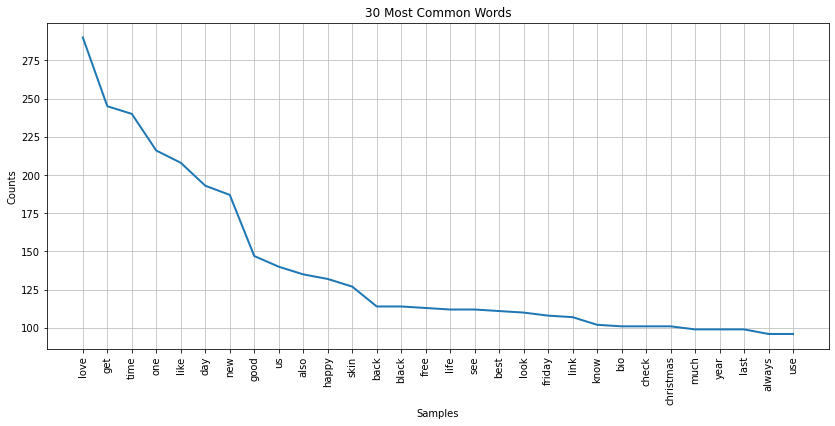

<AxesSubplot:title={'center':'30 Most Common Words'}, xlabel='Samples', ylabel='Counts'>

In [287]:
exclusion = ['1','2','3']
word = [each for word in inf_df['Cleaned Caption'] for each in hashtags if each not in exclusion]
fdist = nltk.FreqDist(hashtags)

fig = plt.figure(figsize = (14,6))
fdist.plot(30, cumulative=False, title = '30 Most Common Words')
plt.show()

We can see that "love" gets mentioned most. Also, "bio" and "use" was mentioned quite frequently, which is usually used by sponsored posts where they would prompt and direct viewers to check out their bio for promotions and external links.

**What makes a sponsored post have high engagement?**
* Finding patterns between Engagement Rate and Timestamp of Postdate
* Finding patterns between Posts' count and Time of day

In [284]:
sponsored_df = inf_df[inf_df.Sponsored == 'Yes'] # Create Sponsored subset

avg_er = sponsored_df['Engagement Rate'].groupby(sponsored_df.index.floor('H').strftime('%H:%M:%S')).mean()
fig = go.Figure()
lineplot = fig.add_trace(go.Scatter(x=avg_er.index,y=avg_er))

fig.add_annotation(x='16:00:00', y=4.67,
            text="Peak engagement at 4pm",
            showarrow=True,
            arrowhead=1).update_layout(
    title="Average Engagement Rate of Posts by Time of Day",title_x=0.5,
    xaxis_title="Time",
    yaxis_title="Average Engagement Rate",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)
number_posts = sponsored_df['User'].groupby(sponsored_df.index.floor('H').strftime('%H:%M:%S')).count()
fig = go.Figure()
lineplot = fig.add_trace(go.Scatter(x=number_posts.index,y=number_posts))

fig.add_annotation(x='10:00:00', y=132,
            text="Peak Number of Posts posted at 10am",
            showarrow=True,
            arrowhead=1).update_layout(
    title="Number of Posts by Time of Day",title_x=0.5,
    xaxis_title="Time",
    yaxis_title="Posts Count",
    font=dict(
        family="Courier New, monospace",
        size=14,
    )
)

**Frequency of Sponsorship by Brand**

In [285]:
sponsor_frequency = pd.DataFrame(columns=['Sponsor','Engagement Rate'])

for index, row in sponsored_df[['Sponsor','Engagement Rate']].iterrows():
    for i in row['Sponsor']:
        text = i.replace('@',"")
        if text.isspace():
            continue
        else:
            sponsor_frequency = sponsor_frequency.append(pd.DataFrame({"Sponsor": [text],"Engagement Rate": [row['Engagement Rate']] }))

        
sponsor_frequency.reset_index(drop=True, inplace=True)
s = sponsor_frequency.groupby(['Sponsor']).size().reset_index(name='counts')
s = s.sort_values(by='counts', ascending=False)

fig = px.bar(s.head(20), x='Sponsor', y='counts')
fig.update_layout(title_text='Top 20 Brands that collaborate with Influencer', title_x=0.5)


**Country/Industry that has the most sponsorship**

In [286]:
industry_sponsor_percentage = inf_df[['Industry','Sponsored']]
y = industry_sponsor_percentage.groupby(['Industry']).apply(lambda x: (x['Sponsored'] == "Yes").sum()).reset_index(name = 'Sponsored')
n = industry_sponsor_percentage.groupby(['Industry']).apply(lambda x: (x['Sponsored'] == "No").sum()).reset_index(name = 'NotSponsored')

industry_sponsor_percentage = y.merge(n, left_on='Industry', right_on='Industry')

industry_sponsor_percentage['Percentage'] =  industry_sponsor_percentage.apply(lambda row: (row.Sponsored / (row.Sponsored + row.NotSponsored))*100, axis=1)

industry_sponsor_percentage = industry_sponsor_percentage.sort_values(by='Percentage', ascending=False)
fig = px.bar(industry_sponsor_percentage.head(20), x='Industry', y='Percentage')
fig.update_layout(title_text='Sponsored Post(%) by Industry', title_x=0.5)

country_sponsor_percentage = inf_df[['Country','Sponsored']]
y = country_sponsor_percentage.groupby(['Country']).apply(lambda x: (x['Sponsored'] == "Yes").sum()).reset_index(name = 'Sponsored')
n = country_sponsor_percentage.groupby(['Country']).apply(lambda x: (x['Sponsored'] == "No").sum()).reset_index(name = 'NotSponsored')

country_sponsor_percentage = y.merge(n, left_on='Country', right_on='Country')

country_sponsor_percentage['Percentage'] =  country_sponsor_percentage.apply(lambda row: (row.Sponsored / (row.Sponsored + row.NotSponsored))*100, axis=1)

country_sponsor_percentage = country_sponsor_percentage.sort_values(by='Percentage', ascending=False)
fig = px.bar(country_sponsor_percentage.head(20), x='Country', y='Percentage')
fig.update_layout(title_text='Sponsored Post(%) by Country', title_x=0.5)